# GSS Data


In [73]:
# Loading the data using R provided
library(foreign)
  read.dct <- function(dct, labels.included = "yes") {
      temp <- readLines(dct)
      temp <- temp[grepl("_column", temp)]
      switch(labels.included,
             yes = {
                 pattern <- "_column\\(([0-9]+)\\)\\s+([a-z0-9]+)\\s+(.*)\\s+%([0-9]+)[a-z]\\s+(.*)"
                 classes <- c("numeric", "character", "character", "numeric", "character")
                 N <- 5
                 NAMES <- c("StartPos", "Str", "ColName", "ColWidth", "ColLabel")
             },
             no = {
                 pattern <- "_column\\(([0-9]+)\\)\\s+([a-z0-9]+)\\s+(.*)\\s+%([0-9]+).*"
                 classes <- c("numeric", "character", "character", "numeric")
                 N <- 4
                 NAMES <- c("StartPos", "Str", "ColName", "ColWidth")
             })
      temp_metadata <- setNames(lapply(1:N, function(x) {
          out <- gsub(pattern, paste("\\", x, sep = ""), temp)
          out <- gsub("^\\s+|\\s+$", "", out)
          out <- gsub('\"', "", out, fixed = TRUE)
          class(out) <- classes[x] ; out }), NAMES)
      temp_metadata[["ColName"]] <- make.names(gsub("\\s", "", temp_metadata[["ColName"]]))
      temp_metadata
  }

  read.dat <- function(dat, metadata_var, labels.included = "yes") {
      read.fwf(dat, widths = metadata_var[["ColWidth"]], col.names = metadata_var[["ColName"]])
  }


GSS_metadata <- read.dct("GSS.dct")
GSS_ascii <- read.dat("GSS.dat", GSS_metadata)
attr(GSS_ascii, "col.label") <- GSS_metadata[["ColLabel"]]
GSS <- GSS_ascii
head(GSS)


BALLOT RINCOME INCOME EARNRS UNRELAT ADULTS TEENS PRETEEN BABIES HOMPOP ⋯
1 0      0       0      1      -1      1      0     0       0      1      ⋯
2 0      0       0      0       0      2      0     0       0      2      ⋯
3 0      0       0      2       0      2      1     1       0      4      ⋯
4 0      0       0      2       0      2      0     0       0      2      ⋯
5 0      0       0      1       0      2      0     0       0      2      ⋯
6 0      0       0      1      -1      1      0     0       0      1      ⋯
  FAMILY16 MOBILE16 REG16 RES16 RACE SEX DEGREE EDUC AGE YEAR
1 4        3        2     5     1    2   3      16   23  1972
2 8        2        3     6     1    1   0      10   70  1972
3 1        2        3     6     1    2   1      12   48  1972
4 1        3        0     6     1    2   3      17   27  1972
5 1        2        3     3     1    2   1      12   61  1972
6 1        1        3     6     1    1   1      14   26  1972

# Data cleansing and preparation

In [74]:
# lowercase the GSS column names to match mappings values provided
for( i in colnames(GSS)){
    colnames(GSS)[which(colnames(GSS)==i)] = tolower(i)
 }

head(GSS)
summary(GSS)

ballot rincome income earnrs unrelat adults teens preteen babies hompop ⋯
1 0      0       0      1      -1      1      0     0       0      1      ⋯
2 0      0       0      0       0      2      0     0       0      2      ⋯
3 0      0       0      2       0      2      1     1       0      4      ⋯
4 0      0       0      2       0      2      0     0       0      2      ⋯
5 0      0       0      1       0      2      0     0       0      2      ⋯
6 0      0       0      1      -1      1      0     0       0      1      ⋯
  family16 mobile16 reg16 res16 race sex degree educ age year
1 4        3        2     5     1    2   3      16   23  1972
2 8        2        3     6     1    1   0      10   70  1972
3 1        2        3     6     1    2   1      12   48  1972
4 1        3        0     6     1    2   3      17   27  1972
5 1        2        3     3     1    2   1      12   61  1972
6 1        1        3     6     1    1   1      14   26  1972

     ballot         rincome           income          earnrs     
 Min.   :0.000   Min.   : 0.000   Min.   : 0.00   Min.   :0.000  
 1st Qu.:0.000   1st Qu.: 0.000   1st Qu.: 9.00   1st Qu.:1.000  
 Median :1.000   Median : 8.000   Median :12.00   Median :1.000  
 Mean   :1.373   Mean   : 8.377   Mean   :13.91   Mean   :1.498  
 3rd Qu.:2.000   3rd Qu.:12.000   3rd Qu.:12.00   3rd Qu.:2.000  
 Max.   :4.000   Max.   :99.000   Max.   :99.00   Max.   :9.000  
    unrelat            adults          teens           preteen      
 Min.   :-1.0000   Min.   :1.000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:-1.0000   1st Qu.:1.000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median : 0.0000   Median :2.000   Median :0.0000   Median :0.0000  
 Mean   :-0.1161   Mean   :1.926   Mean   :0.2562   Mean   :0.3313  
 3rd Qu.: 0.0000   3rd Qu.:2.000   3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   : 9.0000   Max.   :9.000   Max.   :9.0000   Max.   :9.0000  
     babies           hompop           region         x

In [75]:
# first, map column values to human readable EXCEPT for continous features listed below in skip_cols
code_mappings = read.table(file='data/code_mappings_tab_delim.txt', sep='\t', header=TRUE)
head(code_mappings)

# loop through each column, and map the code to the text value
# skip listed columns because these have typed answers
library(dplyr)
GSS['jobsat_num'] = GSS['satjob']
skip_cols = data.frame("jobsat_num","year","age","educ","childs","id_","hrs1","hrs2","hompop","babies","teens","preteen","adults","unrelat","earnrs")
columns_gss = names(GSS)

for (i in columns_gss){
    print(i)
    if (i %in% unlist(skip_cols)) {
        print('skipping')
        next
    }
    map_df = data.frame(code_mappings$Code[which(code_mappings$Variable.Name==i)],code_mappings$Label[which(code_mappings$Variable.Name==i)])
    names(map_df)[1] <- i
    names(map_df)[2] <- "to"
    GSS <- merge(x=GSS,y=map_df,by=i,all.x=TRUE,all.y=TRUE)
    GSS[i] = GSS['to']
    GSS['to'] = NULL
    print("done")
}

# make sure it worked
print(head(GSS))



Variable.Position Variable.Name Code Label         
1 0                 ballot        4    Ballot d      
2 0                 ballot        3    Ballot c      
3 0                 ballot        2    Ballot b      
4 0                 ballot        1    Ballot a      
5 0                 ballot        0    Not applicable
6 1                 rincome       99   No answer

[1] "ballot"
[1] "done"
[1] "rincome"
[1] "done"
[1] "income"
[1] "done"
[1] "earnrs"
[1] "skipping"
[1] "unrelat"
[1] "skipping"
[1] "adults"
[1] "skipping"
[1] "teens"
[1] "skipping"
[1] "preteen"
[1] "skipping"
[1] "babies"
[1] "skipping"
[1] "hompop"
[1] "skipping"
[1] "region"
[1] "done"
[1] "xnorcsiz"
[1] "done"
[1] "srcbelt"
[1] "done"
[1] "localnum"
[1] "done"
[1] "supervis"
[1] "done"
[1] "stress"
[1] "done"
[1] "satfin"
[1] "done"
[1] "satjob"
[1] "done"
[1] "health"
[1] "done"
[1] "happy"
[1] "done"
[1] "partyid"
[1] "done"
[1] "size"
[1] "done"
[1] "born"
[1] "done"
[1] "famdif16"
[1] "done"
[1] "marital"
[1] "done"
[1] "indus10"
[1] "done"
[1] "occ10"
[1] "done"
[1] "wrkslf"
[1] "done"
[1] "evwork"
[1] "done"
[1] "hrs2"
[1] "skipping"
[1] "hrs1"
[1] "skipping"
[1] "wrkstat"
[1] "done"
[1] "id_"
[1] "skipping"
[1] "divorce"
[1] "done"
[1] "spwrksta"
[1] "done"
[1] "childs"
[1] "skipping"
[1] "family16"
[1] "done"
[1] "mobile16"
[1] "done"
[1] "reg16"
[1] "done"
[1] "res16"


In [76]:
# # change column names using:
column_name_mappings = read.table(file='data/column_name_mapping_tab_delim.txt', sep='\t', header=TRUE)
head(column_name_mappings)

# loop through each column, and map the code to the text value
columns_gss = names(GSS)

for (i in columns_gss){
    new_column_name = toString(column_name_mappings$Label[which(column_name_mappings$Name==i)][1])
    names(GSS)[names(GSS) == i] <- new_column_name
    
}

print(head(GSS))



Name    Label                              Description Category
1 ballot  Ballot used for interview          NA          NA      
2 rincome Respondents income                 NA          NA      
3 income  Total family income                NA          NA      
4 earnrs  How many in family earned money    NA          NA      
5 unrelat Number in household not related    NA          NA      
6 adults  Household members 18 yrs and older NA          NA

  Rs highest degree Respondents sex Race of respondent
1  1 Lt high school            Male              White
2  1 Lt high school          Female              White
3  1 Lt high school            Male              White
4  1 Lt high school          Female              Black
5  1 Lt high school          Female              White
6  1 Lt high school            Male              White
  Type of place lived in when 16 yrs old Region of residence, age 16
1                          Town lt 50000                 New england
2                                   Farm             W  sou  central
3                          Town lt 50000                     Foreign
4                         City gt 250000                     Pacific
5                          Town lt 50000                 New england
6                         City gt 250000                    Mountain
  Geographic mobility since age 16 Living with parents when 16 yrs old
1                        Same city                  Mother  a

In [77]:
# split out factors from continuous predictors:

# predictors - factors
predictors_factors = data.frame(
    "Was r born in this country",
    "Region of interview",
    "Does r supervise others at work in main job",
    "Political party affiliation",
    "Reason not living with parents",
    "Living with parents when 16 yrs old",
    "Geographic mobility since age 16",
    "Condition of health",
    "How often does r find work stressful",
    "Region of residence, age 16",
    "Type of place lived in when 16 yrs old",
    "Rs industry code (naics 2007)",
    "Rs census occupation code (2010)",
    "R self-emp or works for somebody",
    "Ever work as long as one year",
    "Labor force status",
    "Marital status",
    "Ever been divorced or separated",
    "Spouse labor force status",
    "Race of respondent",
    "Respondents sex",
    "Rs highest degree",
    "Respondents income",
    "Total family income",
    "Number of employees: rs work site",
    "Size of place in 1000s"
)

continuous_factors = data.frame(
    "Age of respondent",
    "How many in family earned money",
    "Number in household not related",
    "Household members 18 yrs and older",
    "Household members 13 thru 17 yrs old",
    "Household members 6 thru 12 yrs old",
    "Household members less than 6 yrs old",
    "Number of persons in household",
    "Number of hours usually work a week",
    "Number of hours worked last week",
    "Number of children",
    "Highest year of school completed"
)

# time series fields
time_fields = data.frame("Gss year for this respondent")

id_fields = data.frame("Respondent id number")

# responses
responses = data.frame(
    "Job or housework", # satisfaction with job
    "Satisfaction with financial situation", 
    "General happiness"
    )


# unknown:
# - Src beltcode
# - Expanded norc  size code

In [78]:
GSS['counter'] = 1

In [79]:
# turn into NANs: "Not applicable" and "No answer" for all columns
library(dplyr)
GSS = na_if(GSS, "Not applicable")
GSS = na_if(GSS, "No answer")
GSS = na_if(GSS, "Dont know")
GSS = na_if(GSS, "Refused")
GSS = na_if(GSS, "No issp")
GSS = na_if(GSS, "Cant choose")

# turn into NANs: 
## 0 age, negative values in any of the continuous_factors
## 9, 99 or 98 in any of the continuous variables - these values map to 'No answer' and 'Dont know'
## Important: this cannot be done for Respondent ID because that makes null IDS, which is not valid

col_names = names(GSS)

for (i in col_names) {
    colname = toString(i)
    if(colname == 'Respondent id number'){
        next
    }
    GSS[colname] = na_if(GSS[colname], "9")
    GSS[colname] = na_if(GSS[colname], "99")
    GSS[colname] = na_if(GSS[colname], "98")
    GSS[colname] = na_if(GSS[colname], "13")
}

GSS$"Age of respondent" = na_if(GSS$"Age of respondent",0)

library(expss) # for using the lt() function below, means "less than"
for (i in continuous_factors) {
    colname = toString(i)
    GSS[colname] = na_if(GSS[colname], lt(0))
}

# remove NA responses
GSS = GSS[!is.na(GSS$"Job or housework"), ]

# Look at that cleaned data!
head(GSS)


Rs highest degree Respondents sex Race of respondent
1  1 Lt high school  Male            White             
4  1 Lt high school  Female          Black             
5  1 Lt high school  Female          White             
6  1 Lt high school  Male            White             
9  1 Lt high school  Male            White             
10 1 Lt high school  Male            White             
   Type of place lived in when 16 yrs old Region of residence, age 16
1  Town lt 50000                          New england                
4  City gt 250000                         Pacific                    
5  Town lt 50000                          New england                
6  City gt 250000                         Mountain                   
9  Town lt 50000                          W  sou  central            
10 Farm                                   E  sou  central            
   Geographic mobility since age 16 Living with parents when 16 yrs old
1  Same city                        Mother  and father                 
4  Same city                        Father                             
5  Same city                        Mother  and father                 
6  Different state                  Mother  and stpfather              
9  Same city                        Father  and stpmother              
10 Same city                        M and f relatives                  
   Spouse labor force status Ever been divorced or separated Labor force status
1  Keeping house             No                              Working fulltime  
4  NA                        NA                              Keeping house     
5  NA                        No                              Working fulltime  
6  Working fulltime          Yes                             Unempl  laid off  
9  NA                        NA                              Keeping house     
10 NA                        NA                              Working fulltime  
   ⋯ Number of persons in household Number of hours usually work a week
1  ⋯ 2                              NA                                 
4  ⋯ 2                              NA                                 
5  ⋯ 2                              NA                                 
6  ⋯ 2                              NA                                 
9  ⋯ 6                              NA                                 
10 ⋯ 1                              NA                                 
   Number of hours worked last week Respondent id number Number of children
1  40                                259                 1                 
4  NA                                197                 8                 
5  35                               1394                 4                 
6  NA                               1358                 1                 
9  NA                                846                 2                 
10 42                               1342                 5                 
   Highest year of school completed Age of respondent
1  10                               56               
4  11                               48               
5  10                               71               
6   8                               36               
9  10                               22               
10 11                               53               
   Gss year for this respondent                        NA counter
1  1984                                                2  1      
4  2000                                                1  1      
5  2014                                                1  1      
6  1993                                                1  1      
9  1984                                                2  1      
10 1987                                                4  1

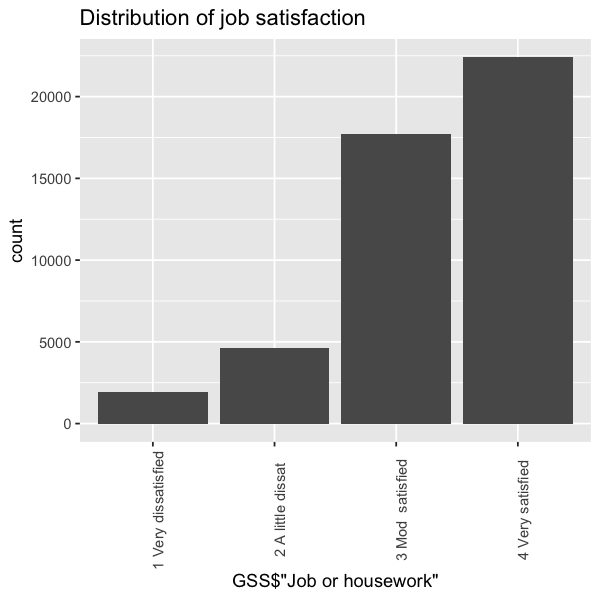

In [80]:
library(ggplot2)

# make the graphs small
options(repr.plot.width=5, repr.plot.height=5)

# counts
ggplot(GSS, aes(x=GSS$'Job or housework',na.rm = TRUE)) +
  geom_bar( na.rm = TRUE)+ 
  theme(axis.text.x = element_text(angle = 90)) +
  ggtitle("Distribution of job satisfaction")


[1] Was r born in this country
Levels: Was r born in this country
[1] Region of interview
Levels: Region of interview


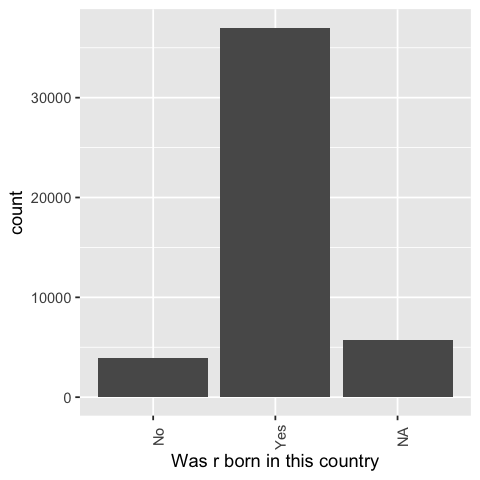

[1] Does r supervise others at work in main job
Levels: Does r supervise others at work in main job


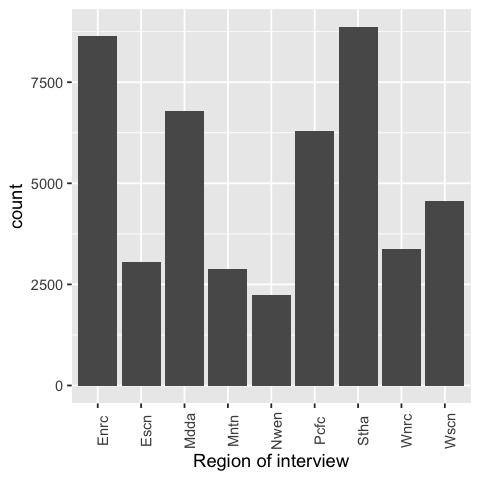

[1] Political party affiliation
Levels: Political party affiliation


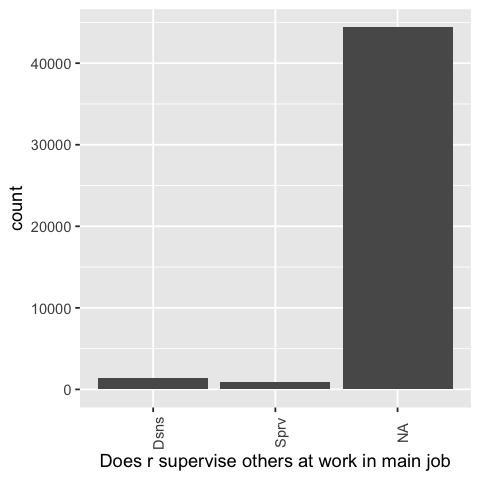

[1] Reason not living with parents
Levels: Reason not living with parents


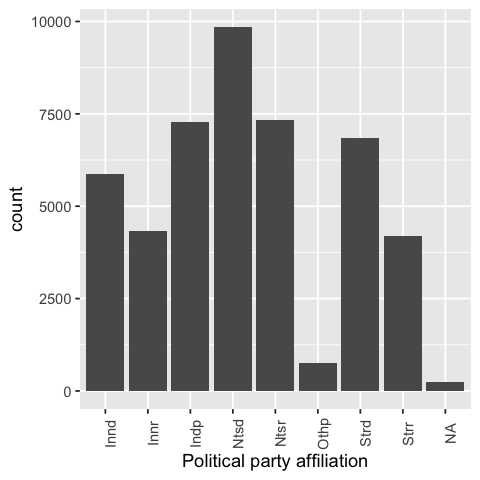

[1] Living with parents when 16 yrs old
Levels: Living with parents when 16 yrs old


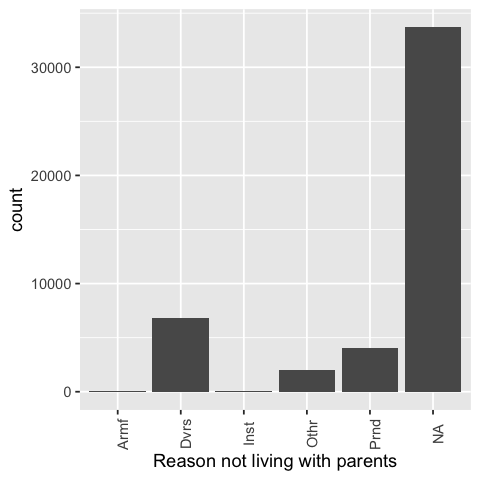

[1] Geographic mobility since age 16
Levels: Geographic mobility since age 16


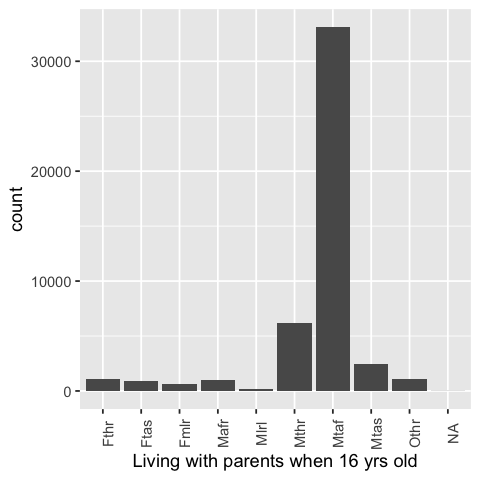

[1] Condition of health
Levels: Condition of health


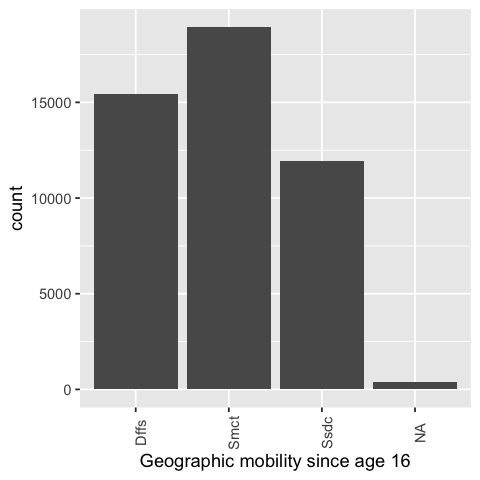

[1] How often does r find work stressful
Levels: How often does r find work stressful


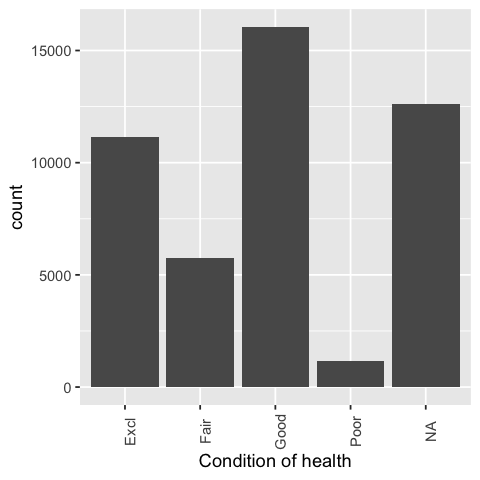

[1] Region of residence, age 16
Levels: Region of residence, age 16


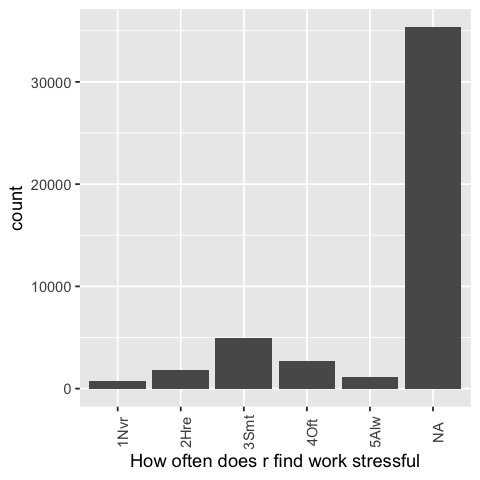

[1] Type of place lived in when 16 yrs old
Levels: Type of place lived in when 16 yrs old


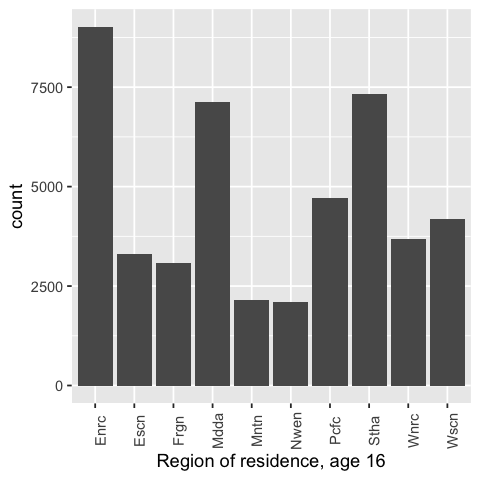

[1] Rs industry code (naics 2007)
Levels: Rs industry code (naics 2007)


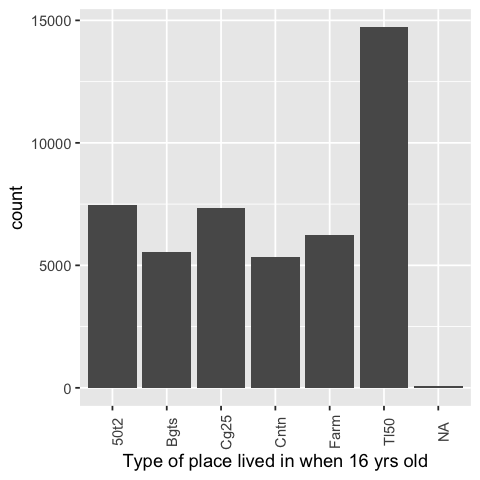

[1] Rs census occupation code (2010)
Levels: Rs census occupation code (2010)


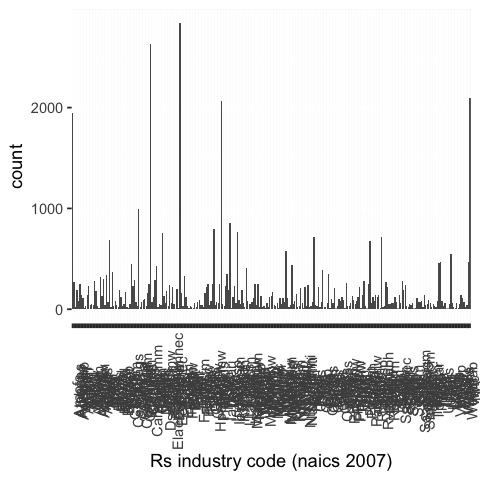

[1] R self-emp or works for somebody
Levels: R self-emp or works for somebody


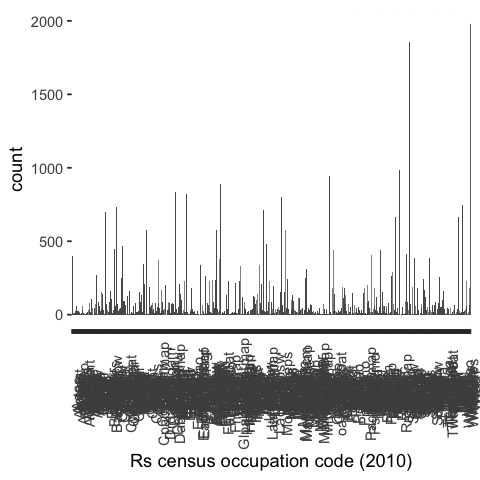

[1] Ever work as long as one year
Levels: Ever work as long as one year


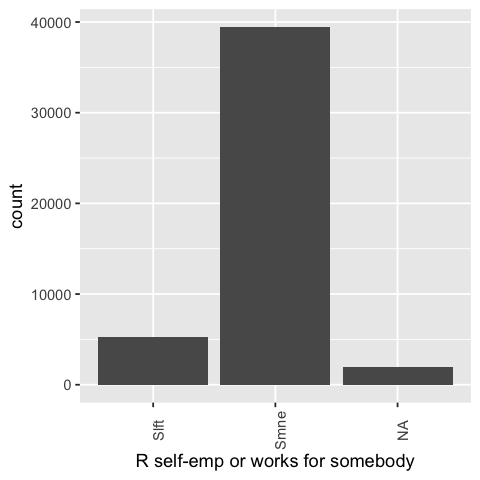

[1] Labor force status
Levels: Labor force status


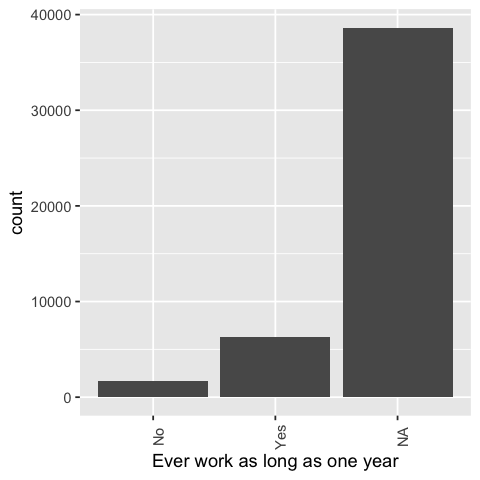

[1] Marital status
Levels: Marital status


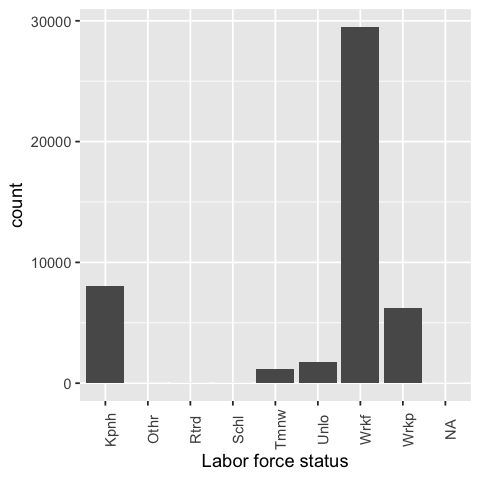

[1] Ever been divorced or separated
Levels: Ever been divorced or separated


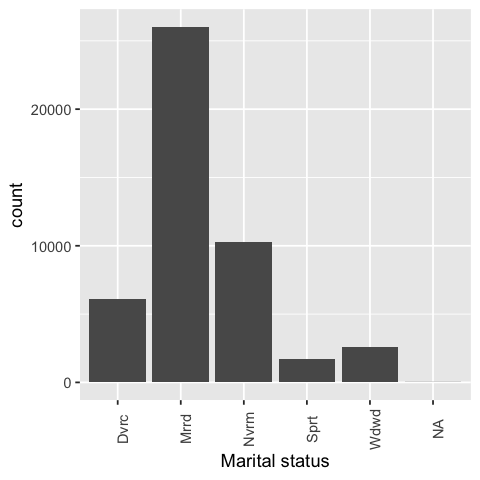

[1] Spouse labor force status
Levels: Spouse labor force status


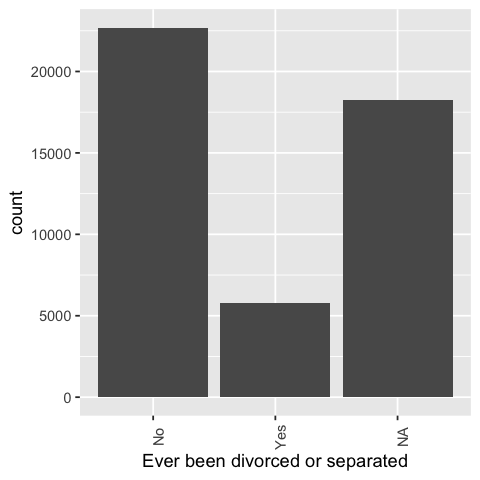

[1] Race of respondent
Levels: Race of respondent


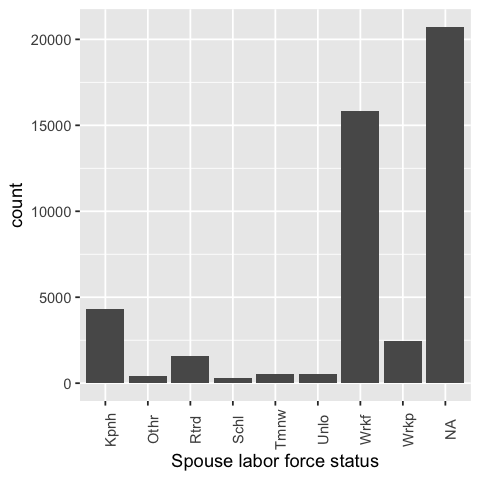

[1] Respondents sex
Levels: Respondents sex


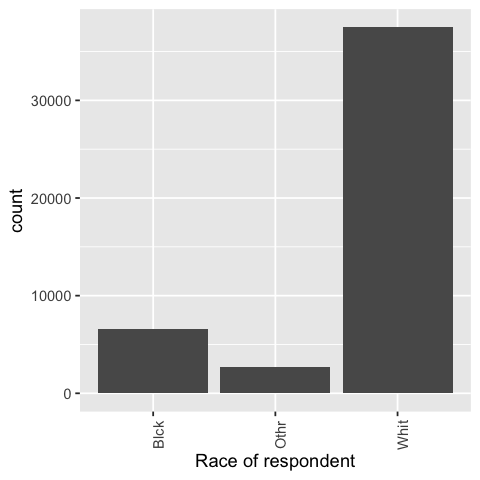

[1] Rs highest degree
Levels: Rs highest degree


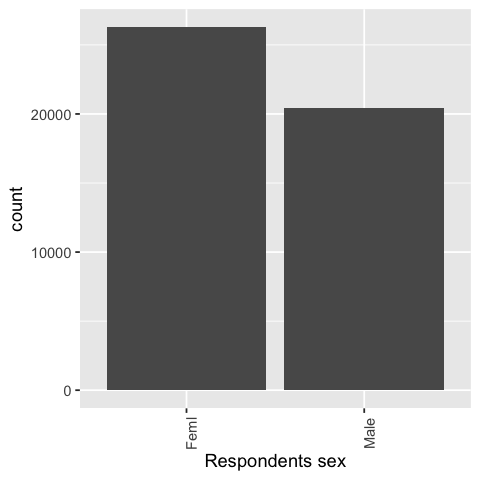

[1] Respondents income
Levels: Respondents income


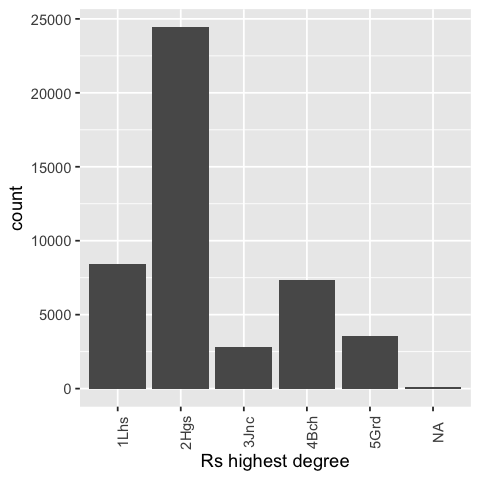

[1] Total family income
Levels: Total family income


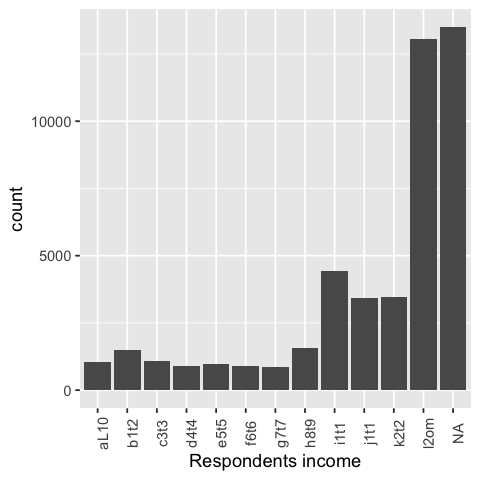

[1] Number of employees: rs work site
Levels: Number of employees: rs work site


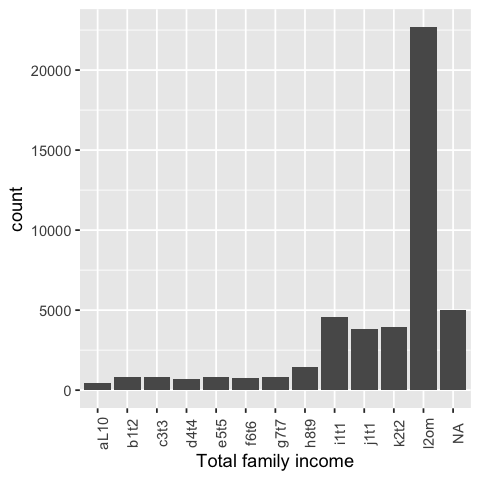

[1] Size of place in 1000s
Levels: Size of place in 1000s


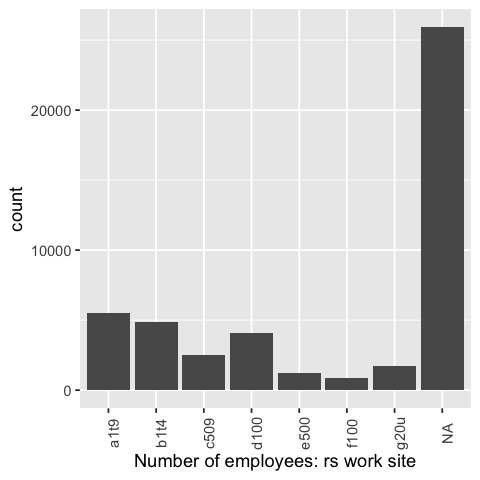

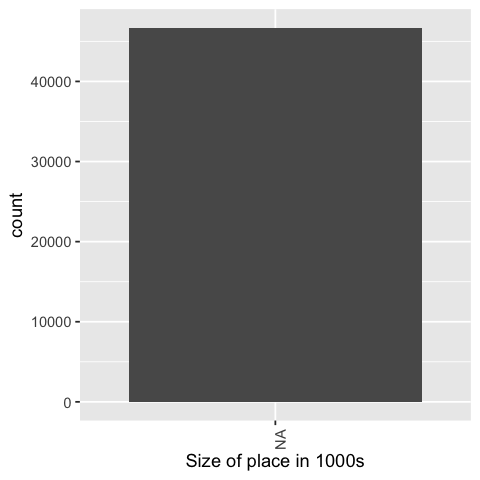

In [81]:
# convert factors predictors into factors
for (i in predictors_factors){
    colname = toString(i)
    GSS[[colname]] = factor(GSS[[colname]])
}


# take a look at them
library(ggplot2)
library(Hmisc)

options(repr.plot.width=4, repr.plot.height=4)

for (i in predictors_factors){
  print(i)
  plot = ggplot(GSS, aes(x=GSS[[toString(i)]])) +
  geom_bar()+ 
  xlab(i) + 
  scale_x_discrete(label=abbreviate)+
  theme(axis.text.x = element_text(angle = 90))
    
  print(plot)
}


In [82]:
# drop unused levels to clean up
GSS = droplevels(GSS)

# review predictors
summary(GSS$"Job or housework")
summary(GSS$"Satisfaction with financial situation")
summary(GSS$"General happiness")

1 Very dissatisfied   2 A little dissat    3 Mod  satisfied    4 Very satisfied 
               1939                4611               17723               22417

1 Not at all sat   2 More or less      3 Satisfied             NA's 
           12640            20892            12635              523

1 Not too happy  2 Pretty happy    3 Very happy            NA's 
           5462           26179           14410             639

[1] Age of respondent
Levels: Age of respondent
 Age of respondent
 Min.   :18.00    
 1st Qu.:30.00    
 Median :40.00    
 Mean   :41.92    
 3rd Qu.:52.00    
 Max.   :89.00    
 NA's   :142      
[1] 1
[1] How many in family earned money
Levels: How many in family earned money
 How many in family earned money
 Min.   :0.000                  
 1st Qu.:1.000                  
 Median :2.000                  
 Mean   :1.632                  
 3rd Qu.:2.000                  
 Max.   :8.000                  
 NA's   :346                    


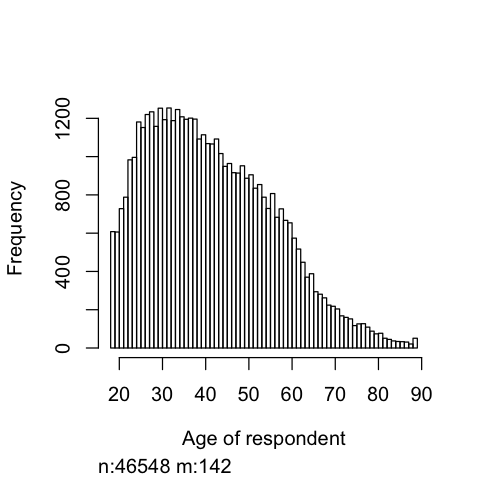

[1] 1
[1] Number in household not related
Levels: Number in household not related
 Number in household not related
 Min.   :0.000                  
 1st Qu.:0.000                  
 Median :0.000                  
 Mean   :0.141                  
 3rd Qu.:0.000                  
 Max.   :8.000                  
 NA's   :10924                  


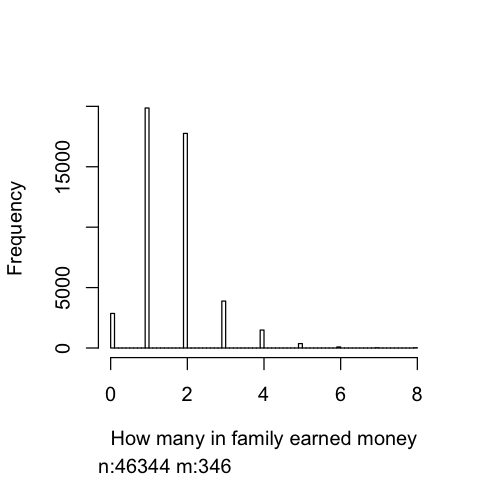

[1] 1
[1] Household members 18 yrs and older
Levels: Household members 18 yrs and older
 Household members 18 yrs and older
 Min.   :1.00                      
 1st Qu.:1.00                      
 Median :2.00                      
 Mean   :1.96                      
 3rd Qu.:2.00                      
 Max.   :8.00                      
 NA's   :56                        


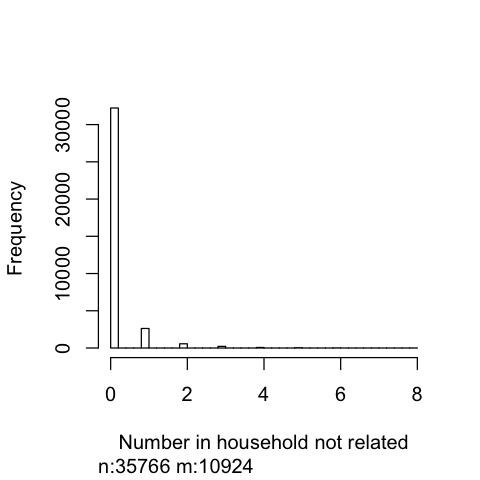

[1] 1
[1] Household members 13 thru 17 yrs old
Levels: Household members 13 thru 17 yrs old
 Household members 13 thru 17 yrs old
 Min.   :0.0000                      
 1st Qu.:0.0000                      
 Median :0.0000                      
 Mean   :0.2496                      
 3rd Qu.:0.0000                      
 Max.   :7.0000                      
 NA's   :251                         


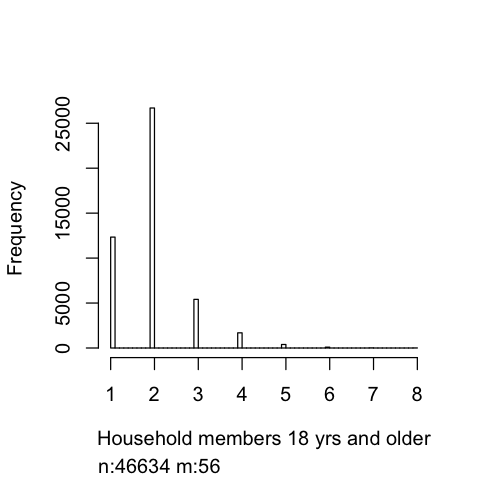

[1] 1
[1] Household members 6 thru 12 yrs old
Levels: Household members 6 thru 12 yrs old
 Household members 6 thru 12 yrs old
 Min.   :0.0000                     
 1st Qu.:0.0000                     
 Median :0.0000                     
 Mean   :0.3306                     
 3rd Qu.:0.0000                     
 Max.   :8.0000                     
 NA's   :322                        


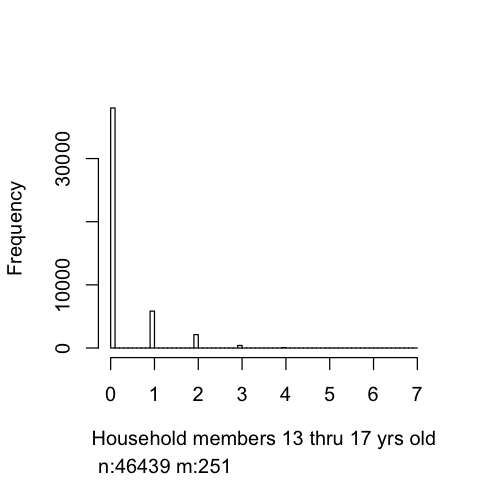

[1] 1
[1] Household members less than 6 yrs old
Levels: Household members less than 6 yrs old
 Household members less than 6 yrs old
 Min.   :0.0000                       
 1st Qu.:0.0000                       
 Median :0.0000                       
 Mean   :0.2687                       
 3rd Qu.:0.0000                       
 Max.   :6.0000                       
 NA's   :300                          


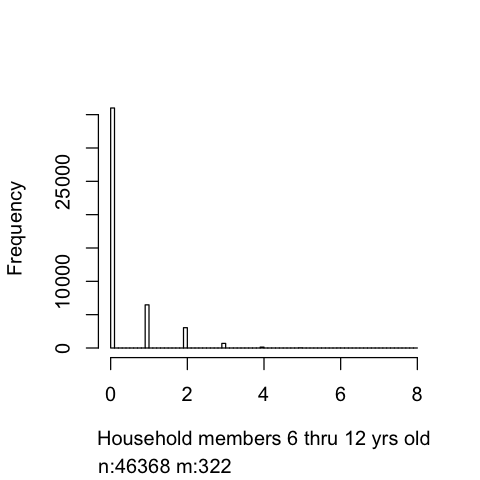

[1] 1
[1] Number of persons in household
Levels: Number of persons in household
 Number of persons in household
 Min.   : 1.000                
 1st Qu.: 2.000                
 Median : 2.000                
 Mean   : 2.802                
 3rd Qu.: 4.000                
 Max.   :16.000                
 NA's   :114                   


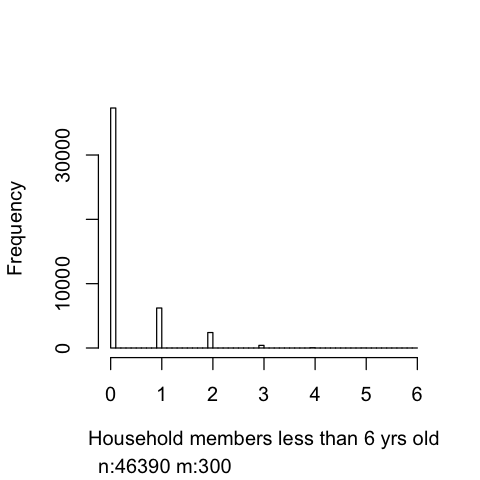

[1] 1
[1] Number of hours usually work a week
Levels: Number of hours usually work a week
 Number of hours usually work a week
 Min.   : 0.00                      
 1st Qu.:35.00                      
 Median :40.00                      
 Mean   :39.17                      
 3rd Qu.:45.00                      
 Max.   :89.00                      
 NA's   :45562                      


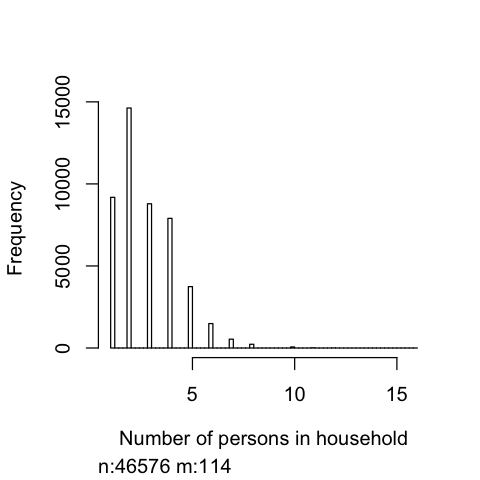

[1] 1
[1] Number of hours worked last week
Levels: Number of hours worked last week
 Number of hours worked last week
 Min.   : 0.00                   
 1st Qu.:37.00                   
 Median :40.00                   
 Mean   :41.34                   
 3rd Qu.:48.00                   
 Max.   :89.00                   
 NA's   :12110                   


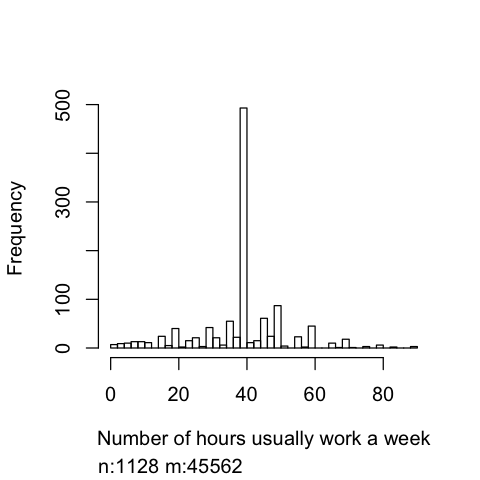

[1] 1
[1] Number of children
Levels: Number of children
 Number of children
 Min.   :0.000     
 1st Qu.:0.000     
 Median :2.000     
 Mean   :1.868     
 3rd Qu.:3.000     
 Max.   :8.000     
 NA's   :114       


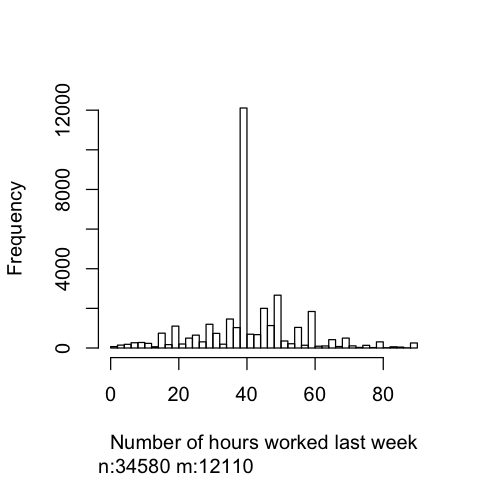

[1] 1
[1] Highest year of school completed
Levels: Highest year of school completed
 Highest year of school completed
 Min.   : 0.00                   
 1st Qu.:12.00                   
 Median :12.00                   
 Mean   :13.23                   
 3rd Qu.:16.00                   
 Max.   :20.00                   
 NA's   :5500                    


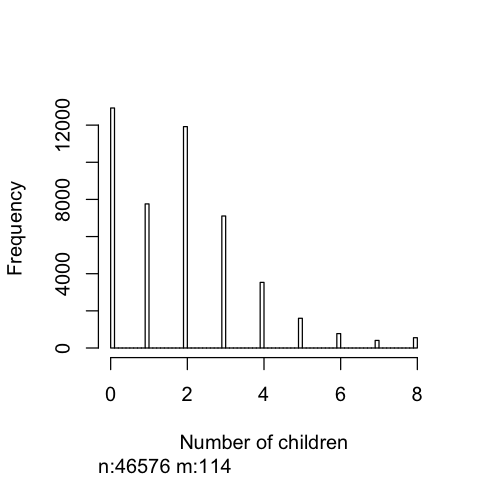

[1] 1


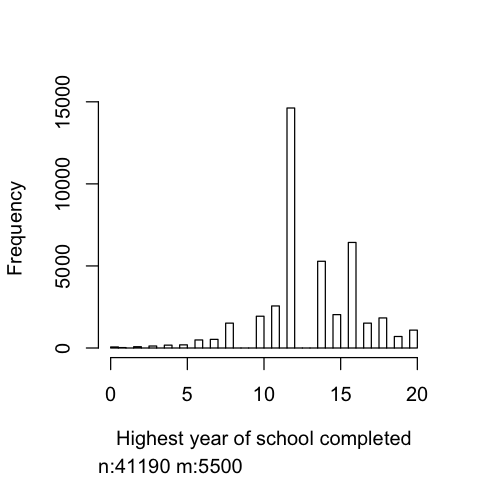

In [83]:
# Plot continuous predictors

for (i in continuous_factors) {
    print(i)
    colname = toString(i)
    print(summary(GSS[colname]))
    print(hist(GSS[colname]))
}


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 45562 rows containing non-finite values (stat_bin).”


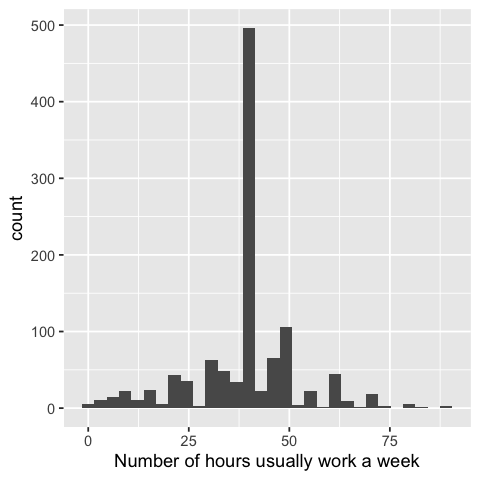

In [59]:
ggplot(GSS, aes(x=`Number of hours usually work a week`)) + geom_histogram()

In [60]:
# Contigency tables

# Age by job satisfaction
xtabs(counter ~ `Job or housework`+`Age of respondent`, data=GSS)

                     Age of respondent
Job or housework       18  19  20  21  22  23  24  25  26  27  28  29  30  31
  1 Very dissatisfied   6  44  53  45  54  51  65  59  64  48  67  51  65  52
  2 A little dissat    19  93 101 109 108 139 148 148 155 128 159 140 131 131
  3 Mod  satisfied     49 232 252 324 367 437 404 513 470 542 500 476 520 505
  4 Very satisfied     31 134 200 250 259 356 379 461 463 502 508 491 537 505
                     Age of respondent
Job or housework       32  33  34  35  36  37  38  39  40  41  42  43  44  45
  1 Very dissatisfied  55  57  50  52  44  44  46  34  44  42  52  49  43  38
  2 A little dissat   128 125  94 122 140 137 125 102 108 102  94  94  90  97
  3 Mod  satisfied    533 474 490 508 448 451 457 415 430 405 397 428 360 356
  4 Very satisfied    538 532 612 526 563 569 568 541 532 519 523 521 523 458
                     Age of respondent
Job or housework       46  47  48  49  50  51  52  53  54  55  56  57  58  59
  1 Very dissatisfied  32

No rows removed (yet)

We changed the values of "Not applicable" and "No Answer" and "Dont know" to R's encoded NAs

# Regression sandbox

In [61]:
#*** fit ordinal logistic regression on a few easy variables just to see if it's the right direction
# not final model, just a sandbox

library(MASS)

olrmod_job <- polr(`Job or housework` ~ 
                   `R self-emp or works for somebody` + 
                   `Respondents income` + 
                   `How often does r find work stressful` + 
                   `Number of hours usually work a week`, data = GSS, Hess = TRUE)
summary(olrmod_job)


Call:
polr(formula = `Job or housework` ~ `R self-emp or works for somebody` + 
    `Respondents income` + `How often does r find work stressful` + 
    `Number of hours usually work a week`, data = GSS, Hess = TRUE)

Coefficients:
                                                       Value Std. Error
`R self-emp or works for somebody`Someone else      -0.07167   0.359807
`Respondents income`b 1000 to 2999                  -4.38426   1.321731
`Respondents income`c 3000 to 3999                  -1.82402   1.472220
`Respondents income`d 4000 to 4999                  -2.80797   1.448168
`Respondents income`e 5000 to 5999                   5.71478   0.003276
`Respondents income`f 6000 to 6999                  -4.39982   1.537370
`Respondents income`g 7000 to 7999                  -2.22543   1.565071
`Respondents income`h 8000 to 9999                  -2.20930   1.749456
`Respondents income`i 10000 to 14999                -2.15287   1.195865
`Respondents income`j 15000 to 19999            

In [62]:
#*** p values for ordinal logistic regression
summary_table <- coef(summary(olrmod_job))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table

Value       Std. Error 
`R self-emp or works for somebody`Someone else      -0.07167376 0.359807167
`Respondents income`b 1000 to 2999                  -4.38425850 1.321731348
`Respondents income`c 3000 to 3999                  -1.82401702 1.472219851
`Respondents income`d 4000 to 4999                  -2.80796939 1.448167979
`Respondents income`e 5000 to 5999                   5.71478108 0.003276002
`Respondents income`f 6000 to 6999                  -4.39982232 1.537370222
`Respondents income`g 7000 to 7999                  -2.22542796 1.565070960
`Respondents income`h 8000 to 9999                  -2.20930162 1.749455673
`Respondents income`i 10000 to 14999                -2.15286543 1.195864798
`Respondents income`j 15000 to 19999                -3.24131417 1.236839561
`Respondents income`k 20000 to 24999                -2.15457995 1.220734036
`Respondents income`l 25000 or more                 -2.39376059 1.166752242
`How often does r find work stressful`2 Hardly ever  0.19317363 0.601779685
`How often does r find work stressful`3 Sometimes   -0.75861071 0.543516061
`How often does r find work stressful`4 Often       -0.89655653 0.561932370
`How often does r find work stressful`5 Always      -2.17895769 0.604836910
`Number of hours usually work a week`                0.01067261 0.010026390
1 Very dissatisfied|2 A little dissat               -6.10019314 1.320300434
2 A little dissat|3 Mod  satisfied                  -4.65519256 1.294605356
3 Mod  satisfied|4 Very satisfied                   -2.72246089 1.276348785
                                                    t value      p value
`R self-emp or works for somebody`Someone else        -0.1992005 0.842  
`Respondents income`b 1000 to 2999                    -3.3170572 0.001  
`Respondents income`c 3000 to 3999                    -1.2389569 0.215  
`Respondents income`d 4000 to 4999                    -1.9389804 0.053  
`Respondents income`e 5000 to 5999                  1744.4375210 0.000  
`Respondents income`f 6000 to 6999                    -2.8619146 0.004  
`Respondents income`g 7000 to 7999                    -1.4219342 0.155  
`Respondents income`h 8000 to 9999                    -1.2628509 0.207  
`Respondents income`i 10000 to 14999                  -1.8002582 0.072  
`Respondents income`j 15000 to 19999                  -2.6206424 0.009  
`Respondents income`k 20000 to 24999                  -1.7649872 0.078  
`Respondents income`l 25000 or more                   -2.0516443 0.040  
`How often does r find work stressful`2 Hardly ever    0.3210039 0.748  
`How often does r find work stressful`3 Sometimes     -1.3957466 0.163  
`How often does r find work stressful`4 Often         -1.5954883 0.111  
`How often does r find work stressful`5 Always        -3.6025541 0.000  
`Number of hours usually work a week`                  1.0644514 0.287  
1 Very dissatisfied|2 A little dissat                 -4.6203068 0.000  
2 A little dissat|3 Mod  satisfied                    -3.5958391 0.000  
3 Mod  satisfied|4 Very satisfied                     -2.1330070 0.033

In [63]:
# happiness response with job predictors
library(MASS)

olr_happiness_job <- polr(`General happiness` ~ 
                   `R self-emp or works for somebody` + 
                   `Respondents income` + 
                   `How often does r find work stressful` + 
                   `Number of hours usually work a week`, data = GSS, Hess = TRUE)
print(summary(olr_happiness_job))

#*** p values for ordinal logistic regression -- THIS WORKS
summary_table <- coef(summary(olr_happiness_job))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
print(summary_table)

Call:
polr(formula = `General happiness` ~ `R self-emp or works for somebody` + 
    `Respondents income` + `How often does r find work stressful` + 
    `Number of hours usually work a week`, data = GSS, Hess = TRUE)

Coefficients:
                                                        Value Std. Error
`R self-emp or works for somebody`Someone else      -0.514320    0.38389
`Respondents income`b 1000 to 2999                   0.013288    1.19139
`Respondents income`c 3000 to 3999                   1.374948    1.19564
`Respondents income`d 4000 to 4999                   0.651855    1.13768
`Respondents income`e 5000 to 5999                  -0.165071    1.99002
`Respondents income`f 6000 to 6999                   2.896453    1.42236
`Respondents income`g 7000 to 7999                   1.164399    1.31845
`Respondents income`h 8000 to 9999                  -1.771299    1.48845
`Respondents income`i 10000 to 14999                 0.587909    0.88631
`Respondents income`j 15000 to 19999 

In [64]:
# happiness response with age predictor, just out of curiousity
# happiness response with job predictors
library(MASS)

olr_happiness_age <- polr(`General happiness` ~ 
                   `Age of respondent`, data = GSS, Hess = TRUE)
print(summary(olr_happiness_age))

#*** p values for ordinal logistic regression -- THIS WORKS
summary_table <- coef(summary(olr_happiness_age))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
print(summary_table)

Call:
polr(formula = `General happiness` ~ `Age of respondent`, data = GSS, 
    Hess = TRUE)

Coefficients:
                       Value Std. Error t value
`Age of respondent` 0.005666  0.0006363   8.905

Intercepts:
                               Value    Std. Error t value 
1 Not too happy|2 Pretty happy  -1.7714   0.0299   -59.2942
2 Pretty happy|3 Very happy      1.0244   0.0286    35.7738

Residual Deviance: 85976.54 
AIC: 85982.54 
(775 observations deleted due to missingness)
                                     Value   Std. Error    t value p value
`Age of respondent`             0.00566608 0.0006362597   8.905295       0
1 Not too happy|2 Pretty happy -1.77139024 0.0298745990 -59.294193       0
2 Pretty happy|3 Very happy     1.02437736 0.0286348190  35.773838       0


# Handling time component


Attaching package: ‘tidyr’


The following objects are masked from ‘package:expss’:

    contains, nest




  Year            Response Count Proportion
1 1972 1 Very dissatisfied    33 0.03495763
2 1973 1 Very dissatisfied    49 0.04294479
3 1974 1 Very dissatisfied    57 0.04660670
4 1975 1 Very dissatisfied    48 0.04120172
5 1976 1 Very dissatisfied    53 0.04472574
6 1977 1 Very dissatisfied    35 0.02773376


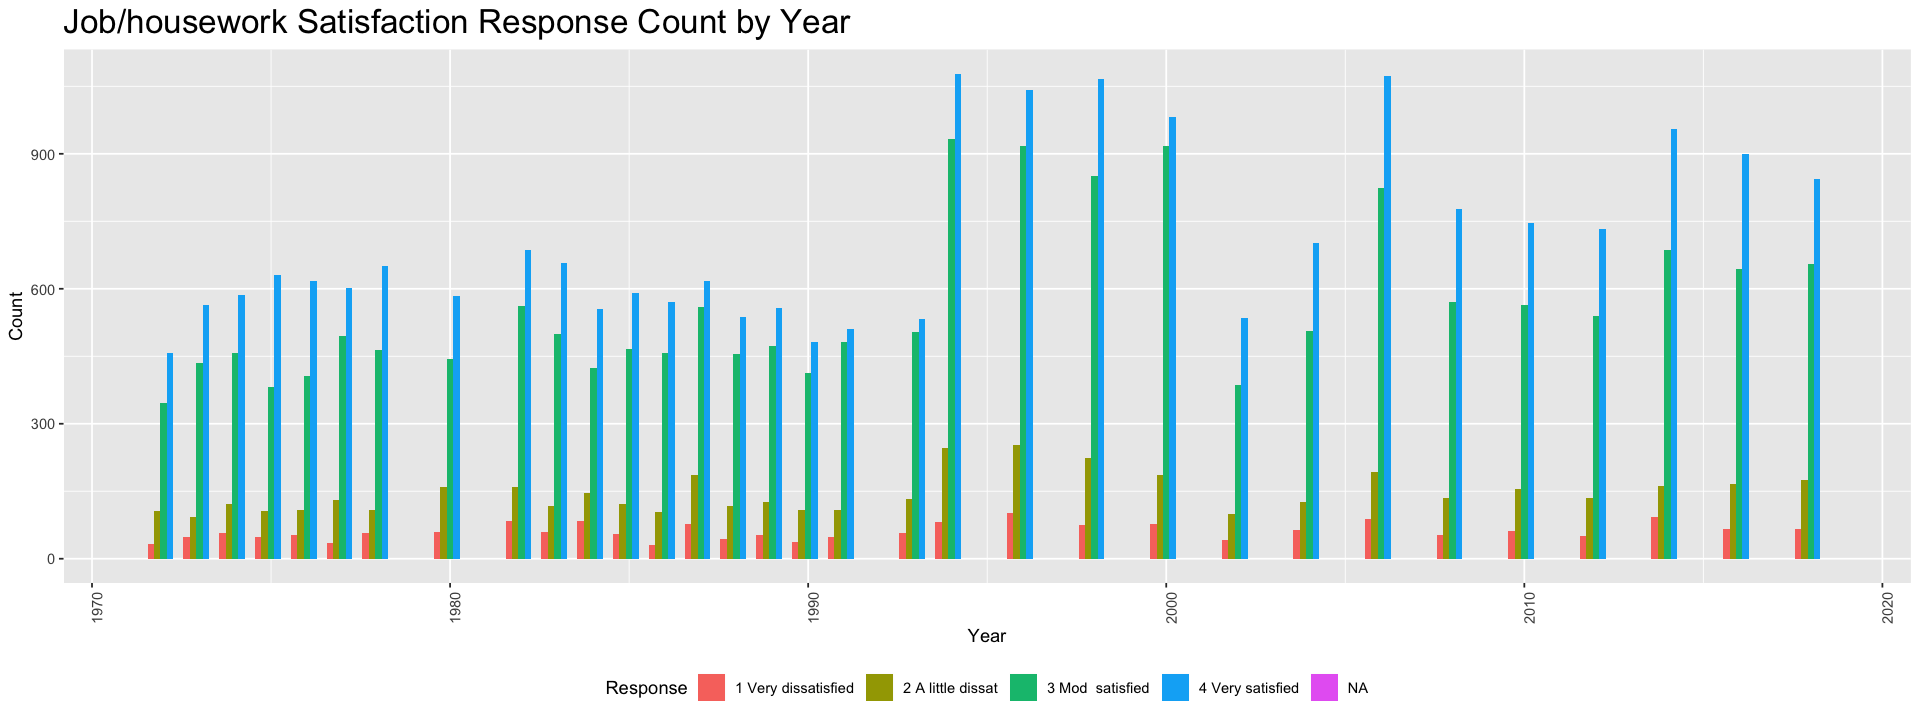

  Year            Response Count Proportion
1 1972 1 Very dissatisfied    33 0.03495763
2 1973 1 Very dissatisfied    49 0.04294479
3 1974 1 Very dissatisfied    57 0.04660670
4 1975 1 Very dissatisfied    48 0.04120172
5 1976 1 Very dissatisfied    53 0.04472574
6 1977 1 Very dissatisfied    35 0.02773376


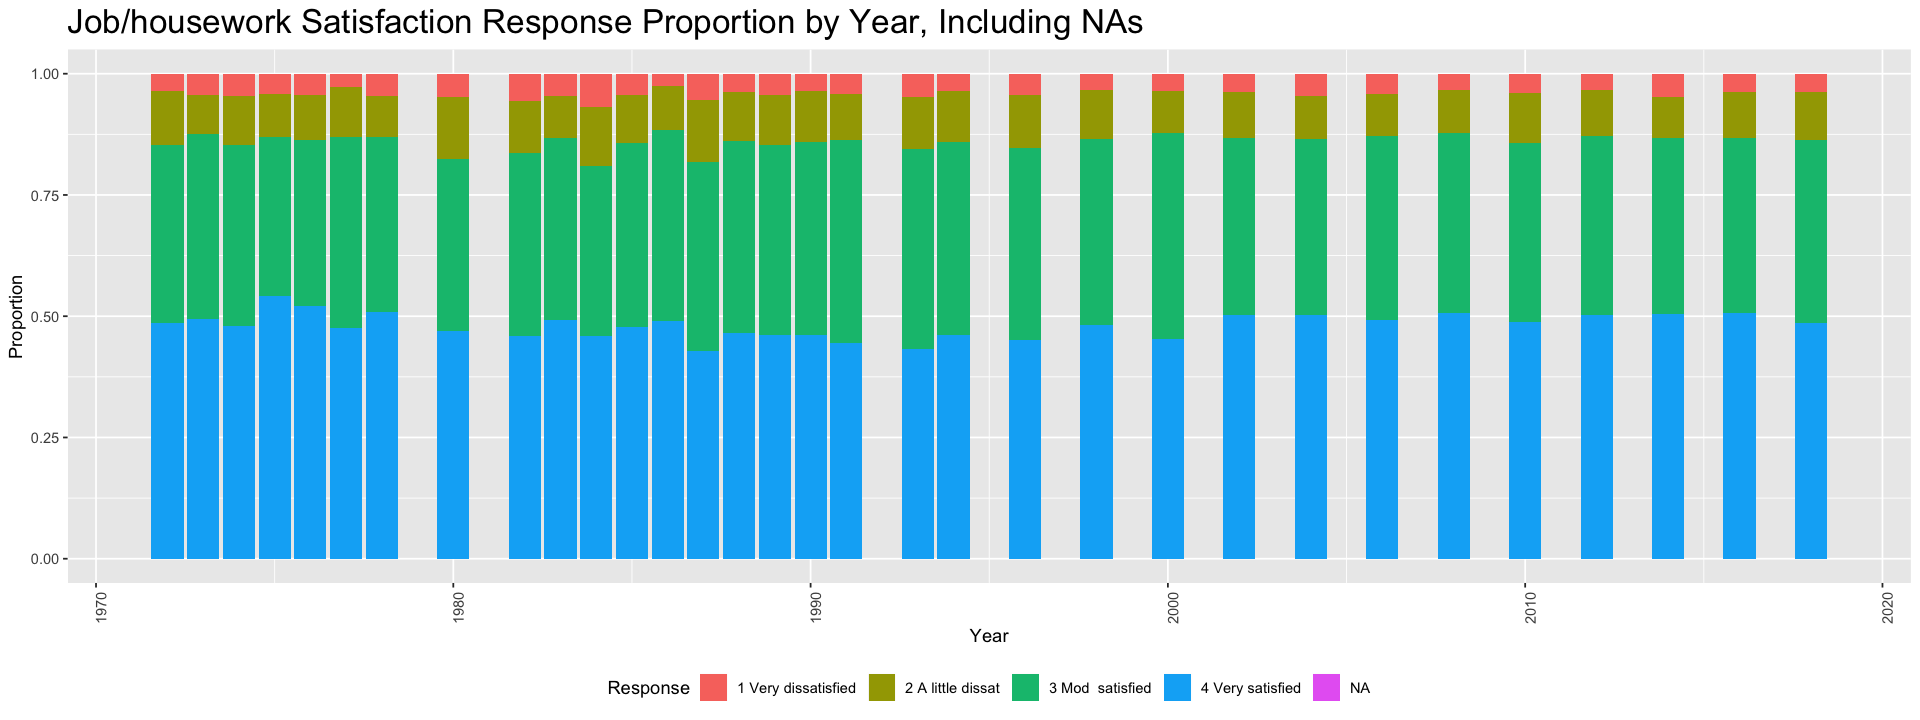

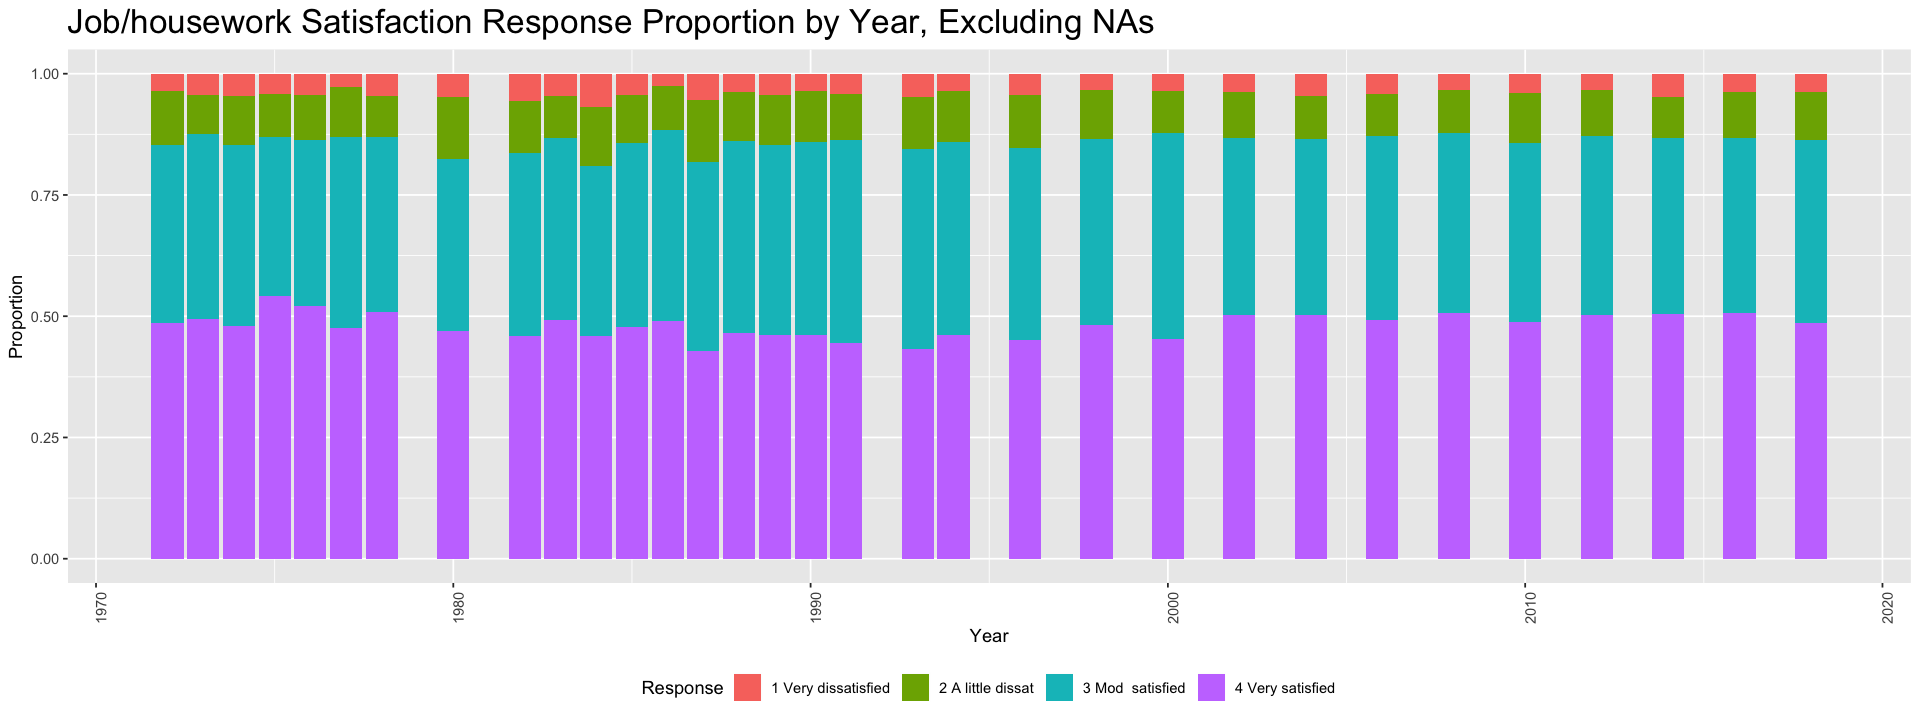

In [18]:
# look at distribution of responses by year

library(tidyr)

# Plot response counts and proportions
plot_resp = function(resp) {
    
    # count number of each response each year
    counts = data.frame()
    options = levels(GSS[1,resp])
    
    for (i in 1972:2018) {
        
        oneyear = c(i)
        for (j in 1:length(options)) {
            oneyear = c(oneyear, 
                        sum(GSS[GSS[resp]==options[j] & GSS$`Gss year for this respondent`==i, "counter"], na.rm = T))
        }
        oneyear = c(oneyear, sum(GSS[is.na(GSS[resp]) & GSS$`Gss year for this respondent`==i, "counter"], na.rm=T))

        counts = rbind(counts, oneyear)      
    }
    
    options = c(options, "NA")
    colnames(counts) = c("Year", options)
    #print(head(counts))
    counts_long <- gather(counts, Response, Count, options[1]:options[length(options)], factor_key=TRUE)
    #print(head(counts_long))

    # calculate proportions of responses
    prop = c()
    for (i in 1:nrow(counts_long)) {
        prop = c(prop, 
                 counts_long$Count[i]/sum(counts_long[counts_long$Year==counts_long[i, "Year"], "Count"]))
    }
    prop[is.na(prop)] = 0
    counts_long$Proportion = prop
    print(head(counts_long))

    return(counts_long)
}

# JOB OR HOUSEWORK

jobsat_counts = plot_resp("Job or housework")

# make the graphs wider
options(repr.plot.width=16, repr.plot.height=6)

# plot absolute frequency
ggplot(jobsat_counts, aes(fill=Response, x=Year, y=Count)) +
  geom_bar(position="dodge", stat="identity", width=0.9) +
  ggtitle("Job/housework Satisfaction Response Count by Year") +
  theme(axis.text.x = element_text(angle = 90), legend.position="bottom", plot.title = element_text(size=20))

# plot relative frequency
ggplot(jobsat_counts, aes(fill=Response, x=Year, y=Proportion)) +
  geom_bar(stat="identity", width=0.9) +
  ggtitle("Job/housework Satisfaction Response Proportion by Year, Including NAs") +
  theme(axis.text.x = element_text(angle = 90), legend.position="bottom", plot.title = element_text(size=20))
  #scale_x_discrete(breaks=seq(1970, 2020, 5))

# plot relative frequency, no NAs

jobsat_noNA = jobsat_counts[jobsat_counts$Response!="NA",]
#tail(jobsat_noNA)
# calculate proportions of responses, no NAs
prop = c()
for (i in 1:nrow(jobsat_noNA)) {
    prop = c(prop, 
             jobsat_noNA$Count[i]/sum(jobsat_noNA[jobsat_noNA$Year==jobsat_noNA[i, "Year"], "Count"]))
}
prop[is.na(prop)] = 0
jobsat_noNA$Proportion = prop
print(head(jobsat_noNA))

ggplot(jobsat_noNA, aes(fill=Response, x=Year, y=Proportion)) +
  geom_bar(stat="identity", width=0.9) +
  ggtitle("Job/housework Satisfaction Response Proportion by Year, Excluding NAs") +
  theme(axis.text.x = element_text(angle = 90), legend.position="bottom", plot.title = element_text(size=20))

# proportions don't change much, data may be indep of year

# Ordinal Regressions sandbox with time component

MVORD library: https://cran.r-project.org/web/packages/mvord/vignettes/vignette_mvord.pdf
> The R package mvord implements composite likelihood estimation in the class of multivariate ordinal regression models with a multivariate probit and a multivariate logit link.
A flexible modeling framework for multiple ordinal measurements on the same subject is
set up, which takes into consideration the dependence among the multiple observations
by employing different error structures. Heterogeneity in the error structure across the
subjects can be accounted for by the package, which allows for covariate dependent error
structures. In addition, different regression coefficients and threshold parameters for each
response are supported. If a reduction of the parameter space is desired, constraints on
the threshold as well as on the regression coefficients can be specified by the user. The
proposed multivariate framework is illustrated by means of a credit risk application

Following Example 5 here: https://cran.r-project.org/web/packages/mvord/vignettes/vignette_mvord2.html#example-5---self-reported-health-status

even better example: https://rdrr.io/cran/mvord/man/mvord.html

In [84]:
library(dplyr)
names(GSS)<-make.names(names(GSS),unique = TRUE)
GSS = rename(GSS, jobsat_num = NA.)
GSS = rename(GSS, Gss.year.for.this.respondent = Gss.year.for.this.respondent.......................)

In [85]:
library(dplyr)

#select subset of data
subset_dat <- GSS$Gss.year.for.this.respondent %in% c("2016","2018") #"2010","2012","2014", takes too long to run
GSS_subset <- GSS[subset_dat,]


# Add columns her to use in mvord/mixor
GSS_job_sat = data.frame(subset(GSS_subset, select=c("Job.or.housework",
                                                     "jobsat_num",
                                                     "R.self.emp.or.works.for.somebody",
                                                     "Respondent.id.number",
                                                     "Gss.year.for.this.respondent",
                                                     "Respondents.income", 
                                                     "How.often.does.r.find.work.stressful",
                                                     "Number.of.hours.usually.work.a.week",
                                                     "Age.of.respondent"
                                                    )))
GSS_job_sat = GSS_job_sat[!is.na(GSS_job_sat$Job.or.housework), ]
GSS_job_sat = GSS_job_sat[!is.na(GSS_job_sat$R.self.emp.or.works.for.somebody), ]
GSS_job_sat = GSS_job_sat[!is.na(GSS_job_sat$Respondents.income), ]
GSS_job_sat = GSS_job_sat[!is.na(GSS_job_sat$How.often.does.r.find.work.stressful), ]
GSS_job_sat = GSS_job_sat[!is.na(GSS_job_sat$Number.of.hours.usually.work.a.week), ]
GSS_job_sat = GSS_job_sat[!is.na(GSS_job_sat$Age.of.respondent), ]
GSS_job_sat = na.omit(GSS_job_sat)
print(head(GSS_job_sat))

       Job.or.housework jobsat_num R.self.emp.or.works.for.somebody
8915   4 Very satisfied          1                   Selftoemployed
9889   3 Mod  satisfied          2                     Someone else
15418  4 Very satisfied          1                     Someone else
15908  4 Very satisfied          1                     Someone else
16385 2 A little dissat          3                     Someone else
18599  3 Mod  satisfied          2                     Someone else
      Respondent.id.number Gss.year.for.this.respondent Respondents.income
8915                   801                         2018   k 20000 to 24999
9889                  2151                         2018    l 25000 or more
15418                 2230                         2016    l 25000 or more
15908                   17                         2016   k 20000 to 24999
16385                 1703                         2018    l 25000 or more
18599                 1711                         2016    l 25000 or more

In [121]:
# using mvord library
# only using 2016 and 2018 data where none of the values listed below are NA
# mvord is not able to handle NAs

library(mvord)
mvord_1 <- mvord(data = GSS_job_sat,
                 formula = MMO(Job.or.housework,Respondent.id.number,Gss.year.for.this.respondent) ~ 
                     Age.of.respondent,
    error.structure = cor_ar1(~ 1), 
    link = mvlogit(), 
    PL.lag = 2)

cat("made model")
print(summary(mvord_1))

Job.or.housework
1 Very dissatisfied   2 A little dissat    3 Mod  satisfied    4 Very satisfied 
         0.04152924          0.09875776          0.37958878          0.48012422 

                     Respondents.income
Job.or.housework       a Lt  1000 b 1000 to 2999 c 3000 to 3999 d 4000 to 4999
  1 Very dissatisfied 0.002198994    0.002650842    0.001596530    0.001385667
  2 A little dissat   0.004247372    0.005422177    0.003765400    0.003434045
  3 Mod  satisfied    0.011778173    0.017863060    0.012772238    0.011808296
  4 Very satisfied    0.013736181    0.019549959    0.014308522    0.010723861
                     Respondents.income
Job.or.housework      e 5000 to 5999 f 6000 to 6999 g 7000 to 7999
  1 Very dissatisfied    0.001626653    0.001265175    0.001626653
  2 A little dissat      0.003283429    0.003283429    0.003042444
  3 Mod  satisfied       0.011145585    0.010272013    0.010844353
  4 Very satisfied       0.012862608    0.011838419    0.010482875
                     Respondents.income
Job.or.housework      h 8000 to 9999 i 10000 to 14999 j 15000 to 19999
  1 Very dissatisfied    0.002138747      0.005723409      0.004066633
  2 A li

Call: xtabs(formula = x ~ Job.or.housework + Respondents.income, data = income_dist)
Number of cases in table: 1 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 0.014742, df = 33, p-value = 1
	Chi-squared approximation may be incorrect

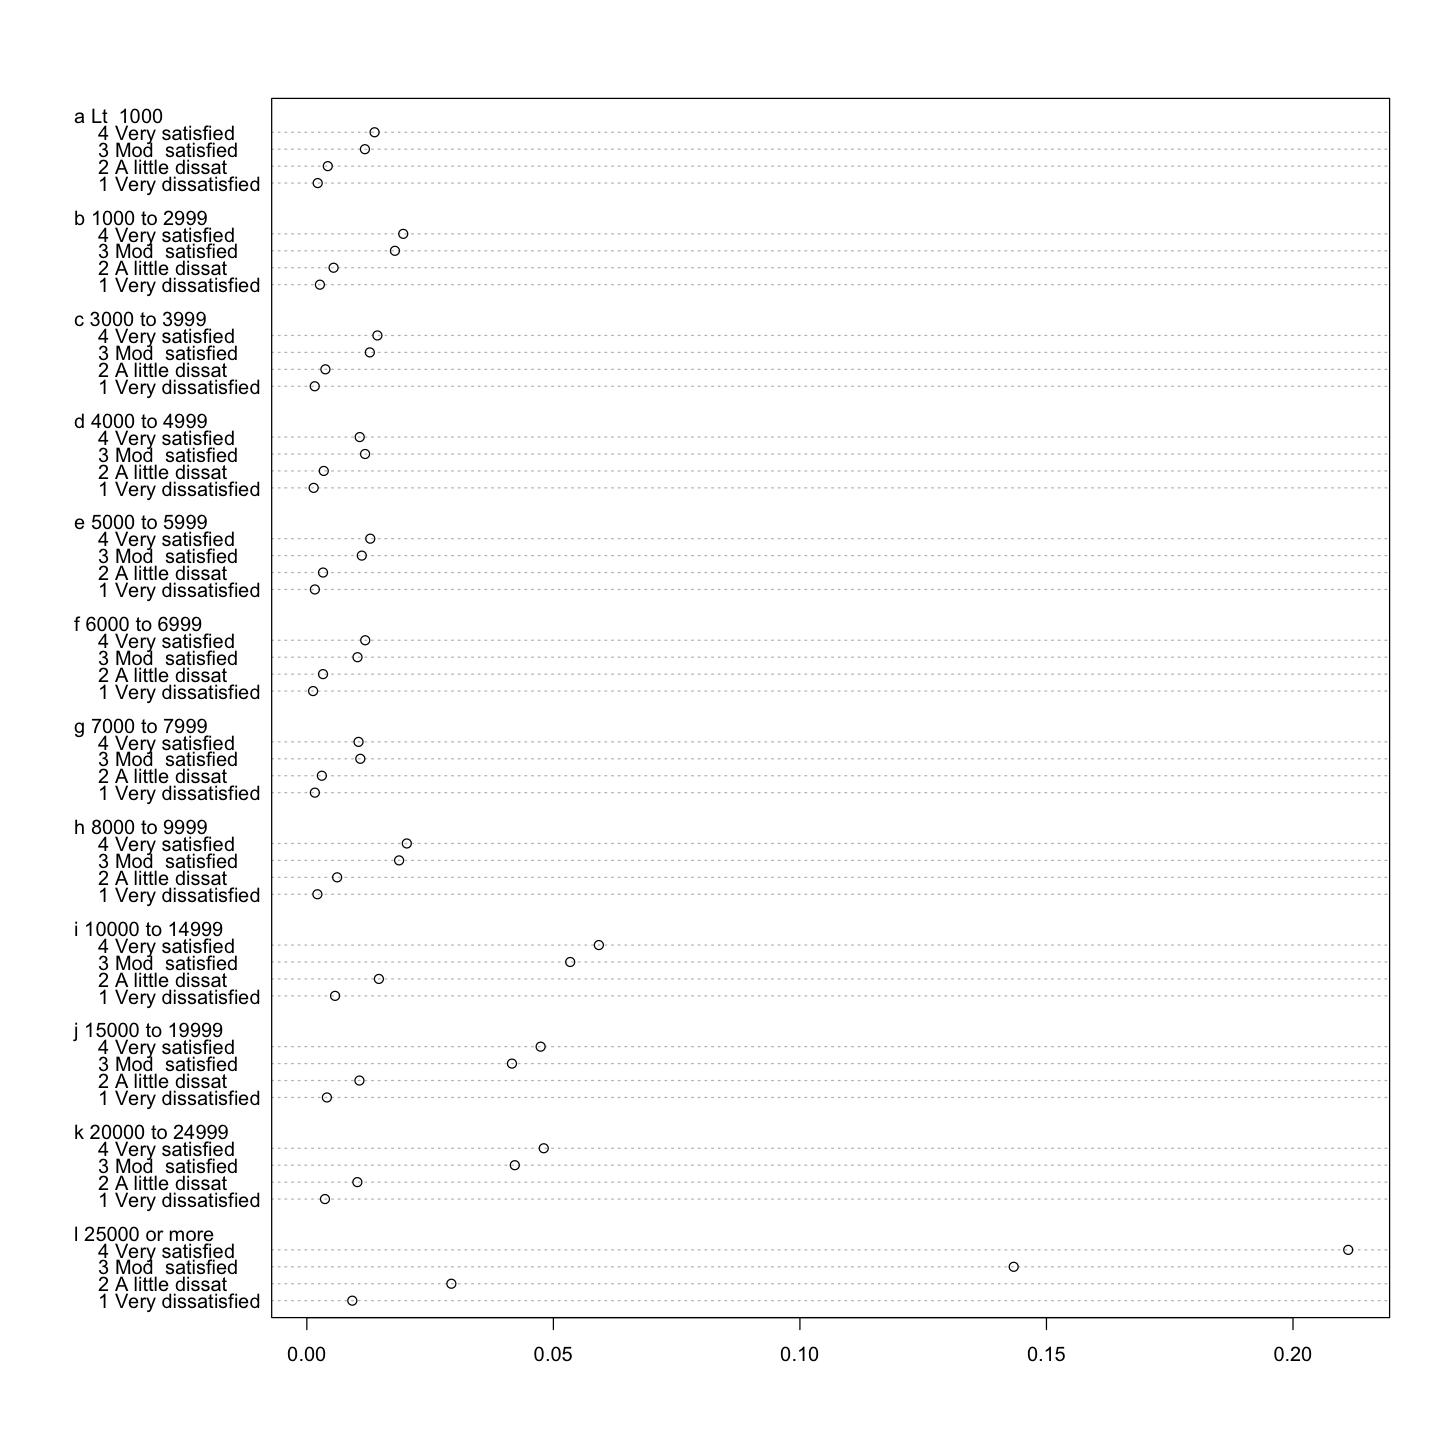

In [22]:
prob_job_sat = prop.table(xtabs(counter ~ Job.or.housework, data=GSS))
prob_job_sat
income_dist = aggregate(GSS$counter, by=list(Job.or.housework=GSS$Job.or.housework,Respondents.income=GSS$Respondents.income), FUN=sum)


prob_job_sat_income = prop.table(xtabs(x ~ Job.or.housework+Respondents.income, data=income_dist))
prob_job_sat_income
summary(prob_job_sat_income) # they are independent, job satisfaction and income
options(repr.plot.width=12, repr.plot.height=12)
dotchart(prob_job_sat_income)
# mosaicplot(prob_job_sat_income)

In [23]:
income_dist = aggregate(GSS$counter, by=list(Job.or.housework=GSS$Job.or.housework,Respondents.income=GSS$Respondents.income), FUN=sum)
print(head(income_dist))
glm_sat_income = glm(Job.or.housework ~ Respondents.income, data=income_dist, family=binomial)
summary(glm_sat_income)

     Job.or.housework Respondents.income   x
1 1 Very dissatisfied         a Lt  1000  73
2   2 A little dissat         a Lt  1000 141
3    3 Mod  satisfied         a Lt  1000 391
4    4 Very satisfied         a Lt  1000 456
5 1 Very dissatisfied     b 1000 to 2999  88
6   2 A little dissat     b 1000 to 2999 180



Call:
glm(formula = Job.or.housework ~ Respondents.income, family = binomial, 
    data = income_dist)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6651   0.1526   0.7585   0.7585   0.7585  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)
(Intercept)                         1.099e+00  1.155e+00   0.951    0.341
Respondents.incomeb 1000 to 2999    5.087e-16  1.633e+00   0.000    1.000
Respondents.incomec 3000 to 3999    1.778e-15  1.633e+00   0.000    1.000
Respondents.incomed 4000 to 4999    1.336e-15  1.633e+00   0.000    1.000
Respondents.incomee 5000 to 5999    1.414e-15  1.633e+00   0.000    1.000
Respondents.incomef 6000 to 6999    6.301e-16  1.633e+00   0.000    1.000
Respondents.incomeg 7000 to 7999    1.142e-15  1.633e+00   0.000    1.000
Respondents.incomeh 8000 to 9999    6.306e-16  1.633e+00   0.000    1.000
Respondents.incomei 10000 to 14999  2.975e-15  1.633e+00   0.000    1.000
Respondents.incomej 15000 t

In [26]:
# using mixor library
library(mixor)

# mixor_df = GSS_job_sat[order(GSS_job_sat$Respondent.id.number, GSS_job_sat$Gss.year.for.this.respondent),]
mixor_df = GSS[order(GSS$Respondent.id.number, GSS$Gss.year.for.this.respondent),]

mixor_1<-mixor(jobsat_num ~ factor(Gss.year.for.this.respondent) + 
 #                factor(R.self.emp.or.works.for.somebody),# +
                 factor(Respondents.income),# +
#                  factor(How.often.does.r.find.work.stressful),# +
#                  factor(Number.of.hours.usually.work.a.week), 
               data=mixor_df, id=Respondent.id.number)

summary(mixor_1)
# No idea why all of these are 0

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”



Call:
mixor(formula = jobsat_num ~ factor(Gss.year.for.this.respondent) + 
    factor(Respondents.income), data = mixor_df, id = Respondent.id.number)

Deviance =         71673.59 
Log-likelihood =  -2482274 
RIDGEMAX =         0 
AIC =             -35882.8 
SBC =             -36024.83 

                                           Estimate Std. Error z value P(>|z|)
(Intercept)                                      NA         NA      NA      NA
factor(Gss.year.for.this.respondent)1973         NA         NA      NA      NA
factor(Gss.year.for.this.respondent)1974         NA         NA      NA      NA
factor(Gss.year.for.this.respondent)1975         NA         NA      NA      NA
factor(Gss.year.for.this.respondent)1976         NA         NA      NA      NA
factor(Gss.year.for.this.respondent)1977         NA         NA      NA      NA
factor(Gss.year.for.this.respondent)1978         NA         NA      NA      NA
factor(Gss.year.for.this.respondent)1980         NA         NA      NA      NA

# More visuals

[1] Age.of.respondent
Levels: Age.of.respondent


Warning message:
“Removed 142 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 142 rows containing missing values (geom_point).”


[1] How.many.in.family.earned.money
Levels: How.many.in.family.earned.money


Warning message:
“Removed 346 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 346 rows containing missing values (geom_point).”


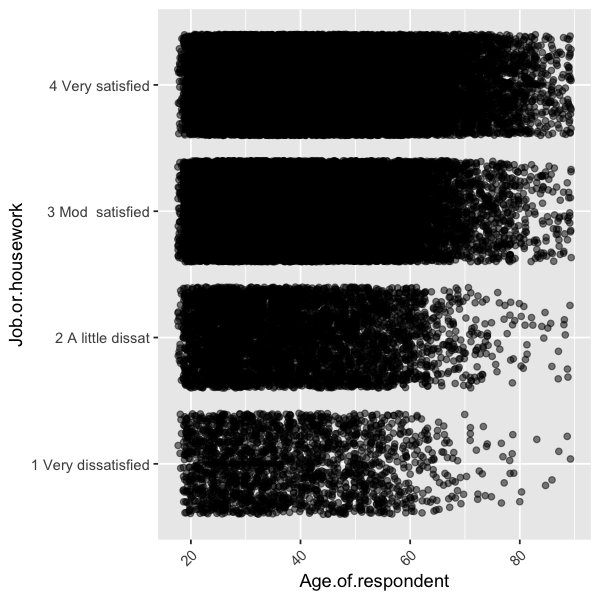

[1] Number.in.household.not.related
Levels: Number.in.household.not.related


Warning message:
“Removed 10924 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 10924 rows containing missing values (geom_point).”


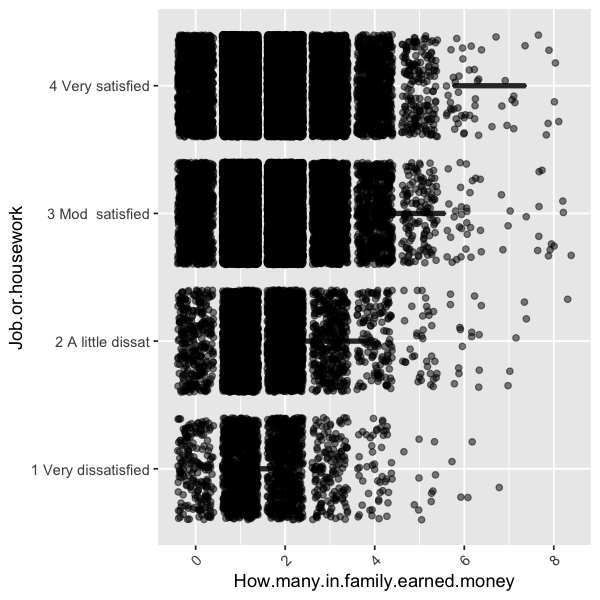

[1] Household.members.18.yrs.and.older
Levels: Household.members.18.yrs.and.older


Warning message:
“Removed 56 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 56 rows containing missing values (geom_point).”


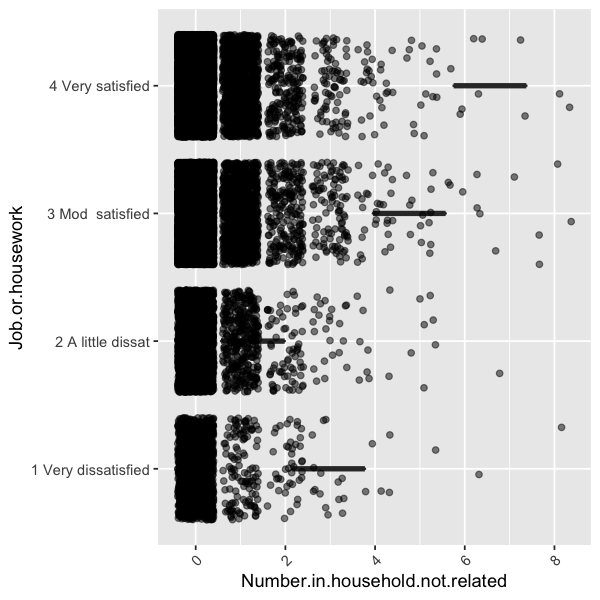

[1] Household.members.13.thru.17.yrs.old
Levels: Household.members.13.thru.17.yrs.old


Warning message:
“Removed 251 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 251 rows containing missing values (geom_point).”


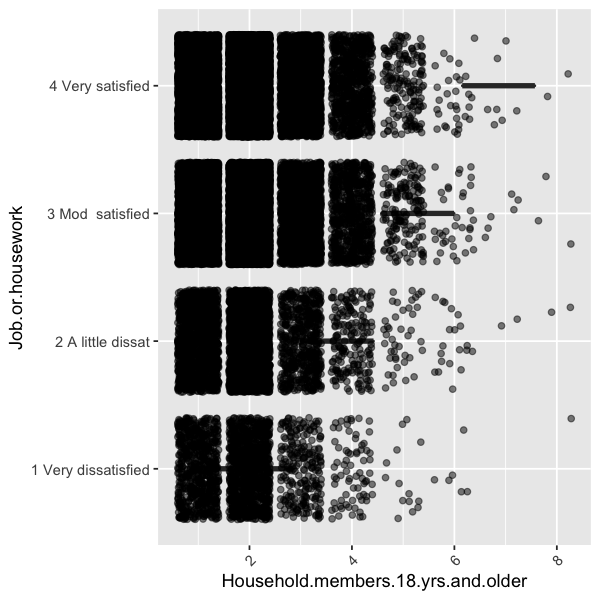

[1] Household.members.6.thru.12.yrs.old
Levels: Household.members.6.thru.12.yrs.old


Warning message:
“Removed 322 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 322 rows containing missing values (geom_point).”


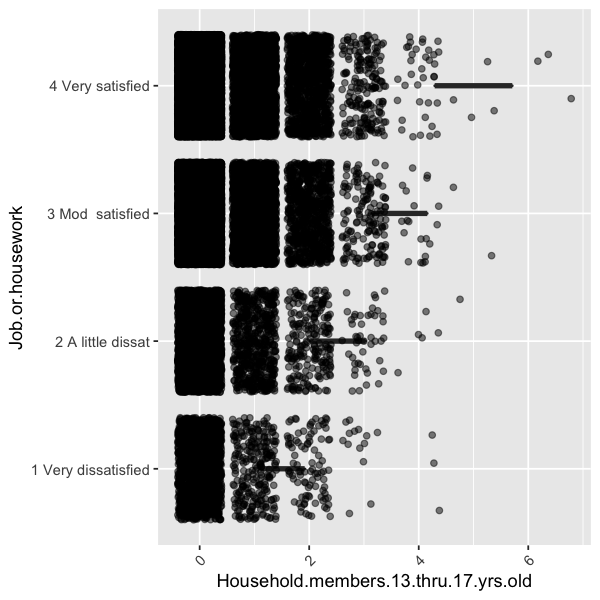

[1] Household.members.less.than.6.yrs.old
Levels: Household.members.less.than.6.yrs.old


Warning message:
“Removed 300 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 300 rows containing missing values (geom_point).”


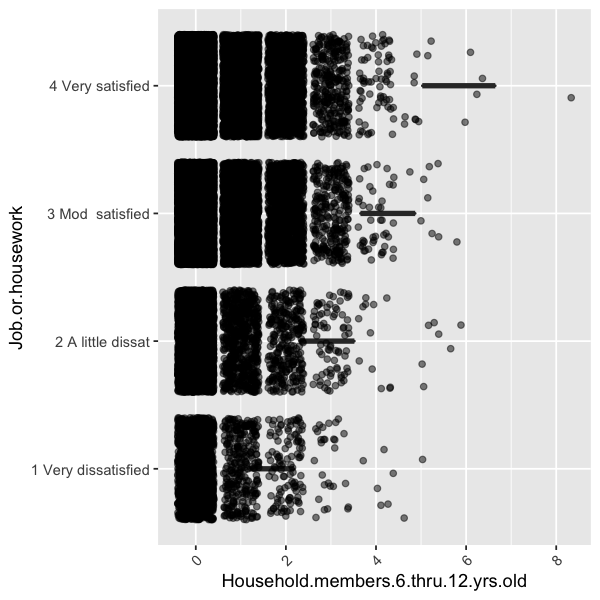

[1] Number.of.persons.in.household
Levels: Number.of.persons.in.household


Warning message:
“Removed 114 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 114 rows containing missing values (geom_point).”


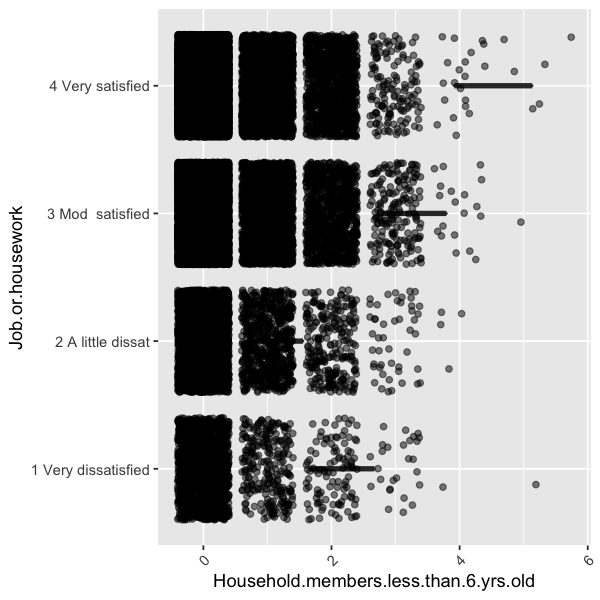

[1] Total.family.income
Levels: Total.family.income


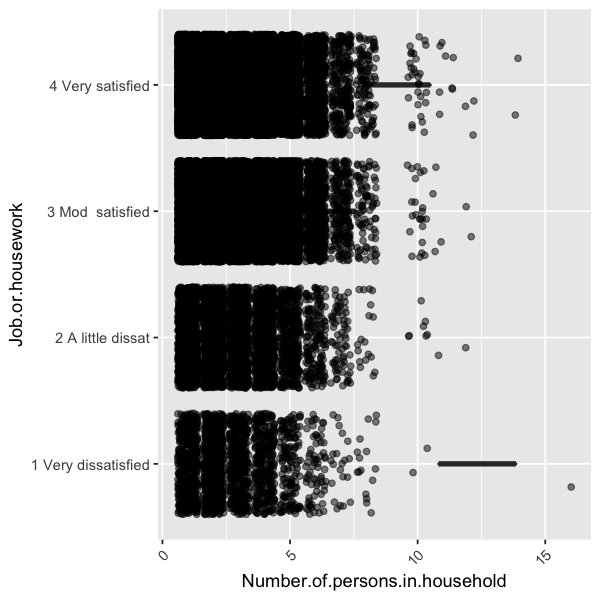

[1] Respondents.income
Levels: Respondents.income


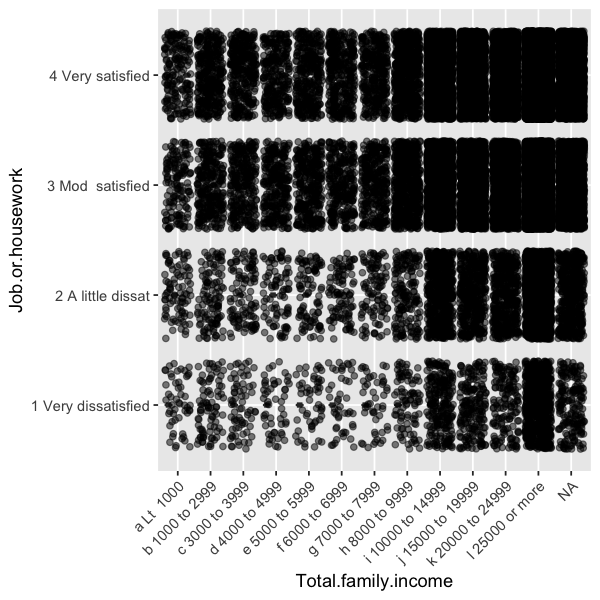

[1] Number.of.employees..rs.work.site
Levels: Number.of.employees..rs.work.site


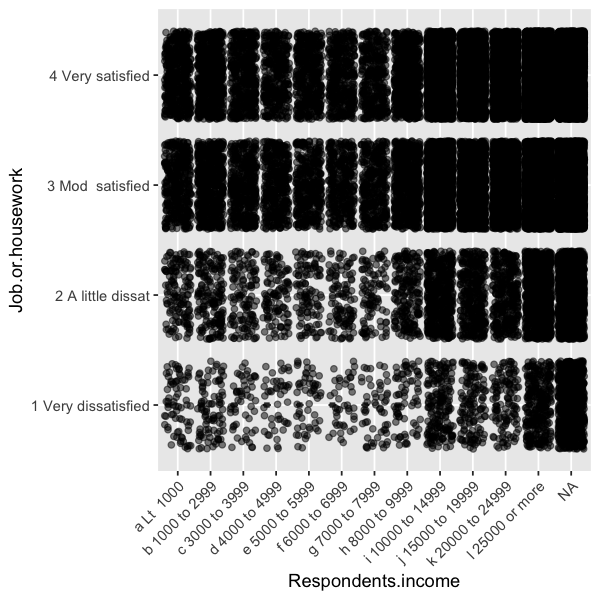

[1] How.often.does.r.find.work.stressful
Levels: How.often.does.r.find.work.stressful


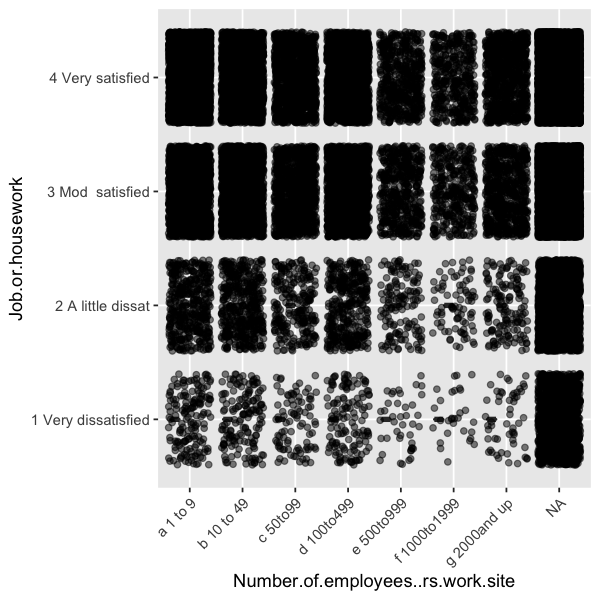

[1] Size.of.place.in.1000s
Levels: Size.of.place.in.1000s


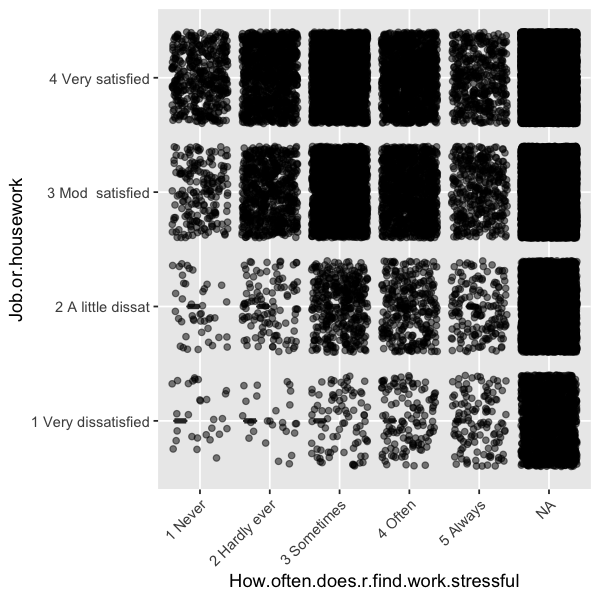

[1] Number.of.hours.usually.work.a.week
Levels: Number.of.hours.usually.work.a.week


Warning message:
“Removed 45562 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 45562 rows containing missing values (geom_point).”


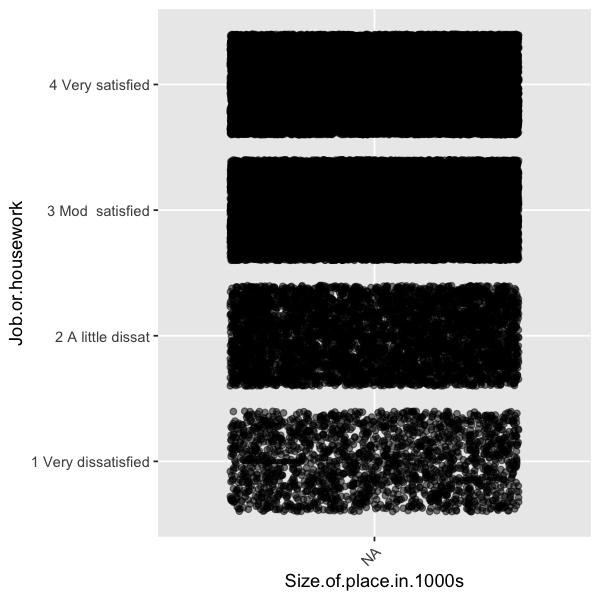

[1] Number.of.hours.worked.last.week
Levels: Number.of.hours.worked.last.week


Warning message:
“Removed 12110 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 12110 rows containing missing values (geom_point).”


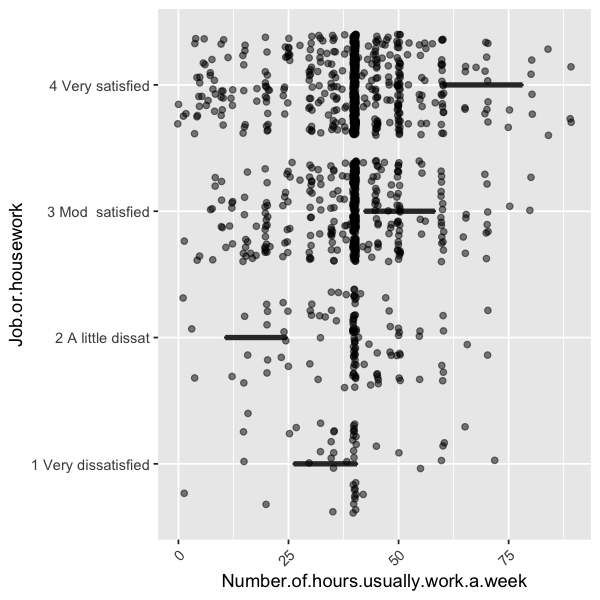

[1] Number.of.children
Levels: Number.of.children


Warning message:
“Removed 114 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 114 rows containing missing values (geom_point).”


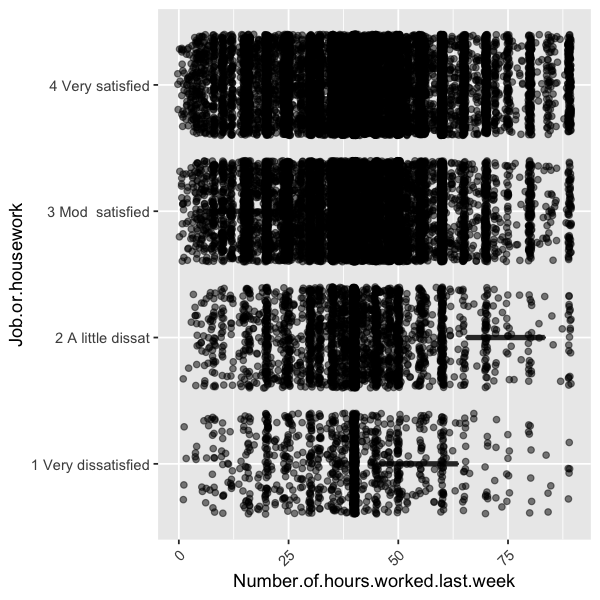

[1] Highest.year.of.school.completed
Levels: Highest.year.of.school.completed


Warning message:
“Removed 5500 rows containing missing values (stat_boxplot).”
Warning message:
“Removed 5500 rows containing missing values (geom_point).”


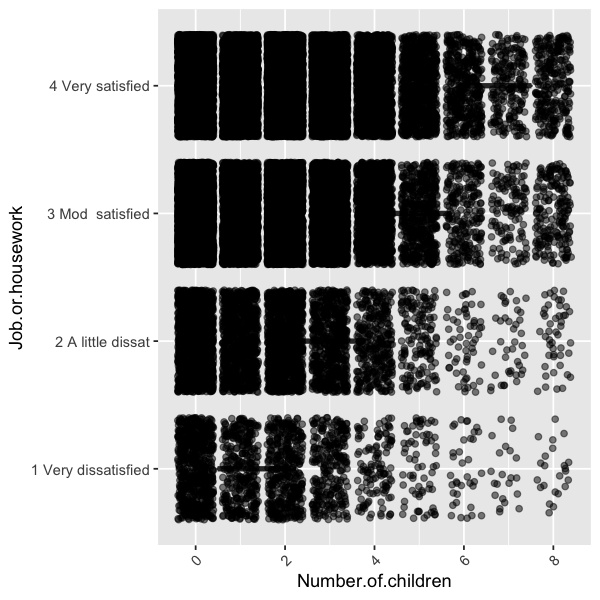

[1] Gss.year.for.this.respondent
Levels: Gss.year.for.this.respondent


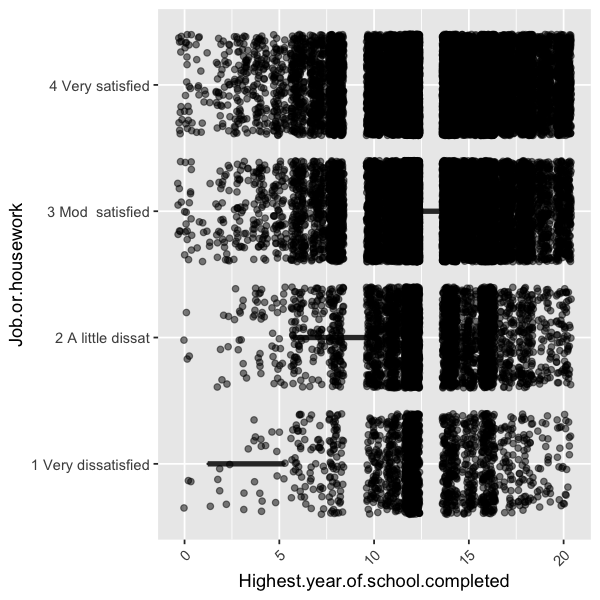

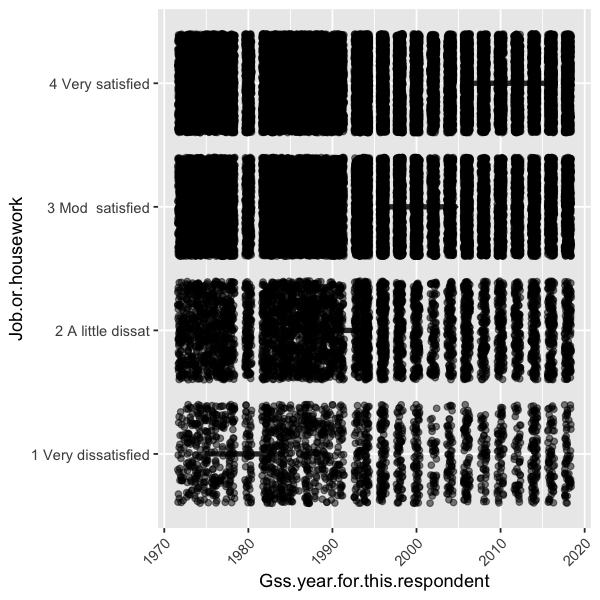

In [28]:
# Great resource: https://stats.idre.ucla.edu/r/dae/ordinal-logistic-regression/
# Plot continuous predictors

continuous_factors_plot = data.frame(
    "Age.of.respondent",
    "How.many.in.family.earned.money",
    "Number.in.household.not.related",
    "Household.members.18.yrs.and.older",
    "Household.members.13.thru.17.yrs.old",
    "Household.members.6.thru.12.yrs.old",
    "Household.members.less.than.6.yrs.old",
    "Number.of.persons.in.household",
    "Total.family.income",
    "Respondents.income",
    "Number.of.employees..rs.work.site",
    "How.often.does.r.find.work.stressful",
    "Size.of.place.in.1000s",
    "Number.of.hours.usually.work.a.week",
    "Number.of.hours.worked.last.week",
    "Number.of.children",
    "Highest.year.of.school.completed",
    "Gss.year.for.this.respondent"
)

GSS = GSS[!is.na(GSS$Job.or.housework), ]
options(repr.plot.width=5, repr.plot.height=5)
for (i in continuous_factors_plot) {
    print(i)
    plot = ggplot(GSS, aes(x = GSS[[toString(i)]],y=Job.or.housework)) +
      geom_boxplot(size = .75) +
      geom_jitter(alpha = .5) +
      xlab(i)+
     # facet_grid(Respondents.income ~ How.often.does.r.find.work.stressful, margins = TRUE) +
      theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
    print(plot)
}

$breaks
 [1]  0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30

$counts
 [1] 926 183 350 339 268 129  42  31  35 126 316 502 352 140  33

$density
 [1] 0.122746554 0.024257688 0.046394486 0.044936373 0.035524920 0.017099682
 [7] 0.005567338 0.004109226 0.004639449 0.016702015 0.041887593 0.066542948
[13] 0.046659597 0.018557794 0.004374337

$mids
 [1]  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29

$xname
[1] "response_dist$x"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"


[1] 0.3750924

Respondent.id.number x         
1     1                   0.7272727 
2     2                   0.8181818 
3     3                   0.7272727 
4     4                   0.8484848 
5     5                   0.6060606 
6     6                   0.6969697 
7     7                   0.8181818 
8     8                   0.6363636 
9     9                   0.8787879 
10   10                   0.6969697 
11   11                   0.7272727 
12   12                   0.6666667 
13   13                   0.6666667 
14   14                   0.7272727 
15   15                   0.7272727 
16   16                   0.8787879 
17   17                   0.6969697 
18   18                   0.7272727 
19   19                   0.7878788 
20   20                   0.6363636 
21   21                   0.7575758 
22   22                   0.7878788 
23   23                   0.6969697 
24   24                   0.6363636 
25   25                   0.5757576 
26   26                   0.6666667 
27   27                   0.6666667 
28   28                   0.7272727 
29   29                   0.7575758 
30   30                   0.7272727 
⋮    ⋮                    ⋮         
3743 4450                 0.03030303
3744 4452                 0.03030303
3745 4453                 0.03030303
3746 4455                 0.03030303
3747 4457                 0.03030303
3748 4461                 0.03030303
3749 4462                 0.03030303
3750 4469                 0.03030303
3751 4470                 0.03030303
3752 4471                 0.03030303
3753 4472                 0.03030303
3754 4473                 0.03030303
3755 4474                 0.03030303
3756 4475                 0.03030303
3757 4477                 0.03030303
3758 4481                 0.03030303
3759 4483                 0.03030303
3760 4485                 0.03030303
3761 4487                 0.03030303
3762 4489                 0.03030303
3763 4490                 0.03030303
3764 4491                 0.03030303
3765 4493                 0.03030303
3766 4494                 0.03030303
3767 4501                 0.03030303
3768 4502                 0.03030303
3769 4505                 0.03030303
3770 4506                 0.03030303
3771 4509                 0.03030303
3772 4510                 0.03030303

Rs.highest.degree Respondents.sex Race.of.respondent
1023  1 Lt high school  Male            White             
2770  1 Lt high school  Female          White             
3407  1 Lt high school  Male            White             
4199  1 Lt high school  Male            White             
12308 1 Lt high school  Female          White             
18719 2 High school     Male            White             
19441 2 High school     Male            White             
23771 2 High school     Male            White             
31036 2 High school     Female          White             
32341 2 High school     Female          White             
34268 2 High school     Female          Black             
37090 2 High school     Female          White             
43995 2 High school     Female          Black             
46742 2 High school     Female          White             
48253 3 Junior college  Male            White             
52411 4 Bachelor        Male            Other             
52576 4 Bachelor        Male            White             
52994 4 Bachelor        Female          White             
54044 4 Bachelor        Male            White             
55809 4 Bachelor        Male            White             
56542 4 Bachelor        Female          White             
58135 4 Bachelor        Male            White             
59862 4 Bachelor        Male            White             
60372 5 Graduate        Male            White             
      Type.of.place.lived.in.when.16.yrs.old Region.of.residence..age.16
1023  Town lt 50000                          Foreign                    
2770  Country nonfarm                        New england                
3407  Town lt 50000                          New england                
4199  City gt 250000                         New england                
12308 Farm                                   New england                
18719 Town lt 50000                          W  sou  central            
19441 City gt 250000                         Middle atlantic            
23771 50000 to 250000                        Foreign                    
31036 Town lt 50000                          W  sou  central            
32341 50000 to 250000                        New england                
34268 City gt 250000                         Middle atlantic            
37090 50000 to 250000                        New england                
43995 City gt 250000                         Foreign                    
46742 City gt 250000                         Foreign                    
48253 Town lt 50000                          Middle atlantic            
52411 City gt 250000                         Middle atlantic            
52576 Bigtocity suburb                       Middle atlantic            
52994 Town lt 50000                          New england                
54044 City gt 250000                         W  sou  central            
55809 Town lt 50000                          New england                
56542 Bigtocity suburb                       Middle atlantic            
58135 Bigtocity suburb                       Middle atlantic            
59862 Town lt 50000                          Middle atlantic            
60372 Bigtocity suburb                       Middle atlantic            
      Geographic.mobility.since.age.16 Living.with.parents.when.16.yrs.old
1023  Different state                  Mother                             
2770  Same city                        Mother                             
3407  Same city                        Mother  and father                 
4199  Same city                        Mother  and father                 
12308 Same st dif city                 Mother  and father                 
18719 Same st dif city                 Mother  and father                 
19441 Same city                        Mother  and father                 
23771 Different state                  Female relative                    
31036 Same city                

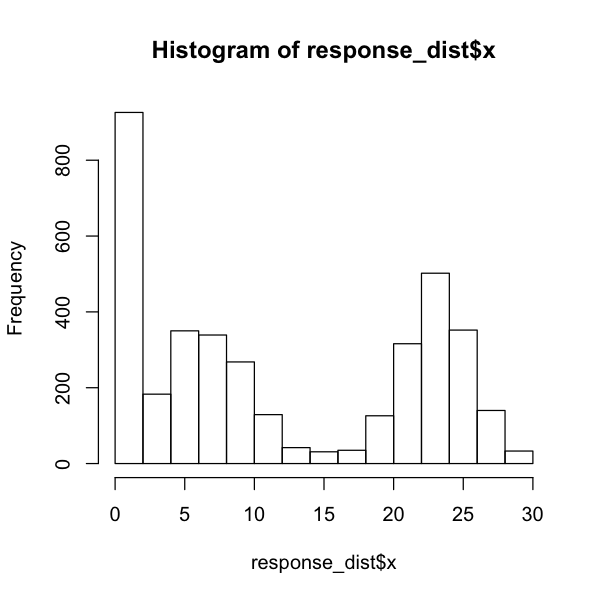

In [30]:
# get total response rate for all respondents for all of time:
response_dist = aggregate(GSS$counter, by=list(Respondent.id.number=GSS$Respondent.id.number), FUN=sum)
print(hist(response_dist$x))
response_rate = aggregate(GSS$counter/33, by=list(Respondent.id.number=GSS$Respondent.id.number), FUN=sum)
mean(response_rate$x)
response_rate

# is respondent 1 the same every year?
respondent_1 = GSS[ which(GSS$Respondent.id.number==1), ]
respondent_1
# NO, trickery.

# Ordinal Regression Sandbox (no time component)

# Hypothesis: factors directly related to job vs. others

In [87]:
# randomly pick 1 year (after 2008 crisis just in case)
set.seed(99)
yr = sample(seq(2010, 2018, by=2), 1) # only have data every other year
yr

subset_yr <- GSS$Gss.year.for.this.respondent == yr
GSS_yr <- GSS[subset_yr,]

[1] 2010

In [114]:
# split data into groups by category (otherwise models don't work)

# job-related variables
job_rel = data.frame(subset(GSS_yr, select=c(Job.or.housework,
#     Does.r.supervise.others.at.work.in.main.job,
    How.often.does.r.find.work.stressful,
    R.self.emp.or.works.for.somebody,
    Labor.force.status,
    Respondents.income,
    Number.of.employees..rs.work.site,
#     Rs industry code (naics 2007), # too many categories
#     Rs census occupation code (2010), # too many categories
#     Ever work as long as one year, # doesn't work, only 887 not NAs: length(job_rel$Ever.work.as.long.as.one.year[!is.na(job_rel$Ever.work.as.long.as.one.year)])
#     Number of hours usually work a week, # doesn't work, only 40 not NAs
    Number.of.hours.worked.last.week)))

# family-related variables
job_family = data.frame(subset(GSS_yr, select=c(Job.or.housework,
    Marital.status,
    Spouse.labor.force.status,
    Number.of.children,
    How.many.in.family.earned.money,
    Number.in.household.not.related,
    Household.members.18.yrs.and.older,
    Household.members.13.thru.17.yrs.old,
    Household.members.6.thru.12.yrs.old,
    Household.members.less.than.6.yrs.old,
    Number.of.persons.in.household,
    Total.family.income)))
#head(job_family)

# personal history variables
job_past = data.frame(subset(GSS_yr, select=c(Job.or.housework,
#    Reason.not.living.with.parents, failed algorithm did not converge
    Was.r.born.in.this.country,
    Living.with.parents.when.16.yrs.old,
    Geographic.mobility.since.age.16,
    Region.of.residence..age.16,
    Type.of.place.lived.in.when.16.yrs.old,
    Ever.been.divorced.or.separated))) # family?
#head(job_past)

# other variables
job_other = data.frame(subset(GSS_yr, select=c(Job.or.housework,
    Region.of.interview,
    Political.party.affiliation,
    Condition.of.health,
    Race.of.respondent,
    Respondents.sex,
    Rs.highest.degree,
    Age.of.respondent,
    Highest.year.of.school.completed)))
#head(job_other)

job_all = cbind(job_rel, job_family[,-1], job_past[,-1], job_other[,-1])
#head(job_all)

job_rel_family = cbind(job_rel, job_family[,-1])
job_rel_past = cbind(job_rel, job_past[,-1])
job_rel_other = cbind(job_rel, job_other[,-1])

In [105]:
print(head(job_all))

       Job.or.housework How.often.does.r.find.work.stressful
166    3 Mod  satisfied                                 <NA>
175    3 Mod  satisfied                              4 Often
246    3 Mod  satisfied                                 <NA>
279    3 Mod  satisfied                              4 Often
305 1 Very dissatisfied                          3 Sometimes
361    4 Very satisfied                          3 Sometimes
    R.self.emp.or.works.for.somebody Labor.force.status Respondents.income
166                     Someone else      Keeping house               <NA>
175                     Someone else   Working fulltime     f 6000 to 6999
246                     Someone else   Unempl  laid off               <NA>
279                     Someone else   Working fulltime    l 25000 or more
305                     Someone else   Working fulltime    l 25000 or more
361                     Someone else   Working fulltime     b 1000 to 2999
    Number.of.employees..rs.work.site Number.of.

In [115]:
# full model - DOESN'T WORK
library(MASS)

olrmod_job_all <- polr(Job.or.housework ~ ., data = job_all, Hess = TRUE)
summary(olrmod_job_all)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


ERROR: Error in polr(Job.or.housework ~ ., data = job_all, Hess = TRUE): attempt to find suitable starting values failed


After include too many, get error
"attempt to find suitable starting values failed"

Maybe because:

"There is one fairly common circumstance in which both convergence problems and the Hauck-Donner phenomenon can occur. This is when the fitted probabilities are extremely close to zero or one. Consider a medical diagnosis problem with thousands of cases and around 50 binary explanatory variable (which may arise from coding fewer categorical variables); one of these indicators is rarely true but always indicates that the disease is present. Then the fitted probabilities of cases with that indicator should be one, which can only be achieved by taking βi = ∞. The result from glm will be warnings and an estimated coefficient of around +/- 10. There has been fairly extensive discussion of this in the statistical literature, usually claiming non-existence of maximum likelihood estimates; see Sautner and Duffy (1989, p. 234)."

https://stackoverflow.com/questions/55416164/ordinal-logistic-regression-in-r
https://stackoverflow.com/questions/8596160/why-am-i-getting-algorithm-did-not-converge-and-fitted-prob-numerically-0-or

In [107]:
# construct a model for each category

# partial model: job-related variables
olrmod_job_rel <- polr(Job.or.housework ~ ., data = job_rel, Hess = TRUE)

cat("Residual Deviance: ", olrmod_job_rel$deviance, "\n")
cat("Degrees of freedom: ", olrmod_job_rel$df.residual, "\n")
cat("p value: ", pchisq(olrmod_job_rel$deviance, olrmod_job_rel$df.residual, lower.tail = FALSE))

# summary with p values for ordinal logistic regression
summary_table <- coef(summary(olrmod_job_rel))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table


Warning message in polr(Job.or.housework ~ ., data = job_rel, Hess = TRUE):
“design appears to be rank-deficient, so dropping some coefs”


Residual Deviance:  1813.771 
Degrees of freedom:  903 
p value:  1.792271e-63

Value       Std. Error 
How.often.does.r.find.work.stressful2 Hardly ever -0.62061815 0.340273509
How.often.does.r.find.work.stressful3 Sometimes   -1.11250876 0.324453367
How.often.does.r.find.work.stressful4 Often       -1.75394060 0.337253167
How.often.does.r.find.work.stressful5 Always      -1.77274457 0.377413310
R.self.emp.or.works.for.somebodySomeone else      -0.50779667 0.235556727
Labor.force.statusWorking fulltime                 0.30060746 0.228350023
Respondents.incomeb 1000 to 2999                  -0.53542318 0.667820581
Respondents.incomec 3000 to 3999                  -0.75874750 0.674492576
Respondents.incomed 4000 to 4999                  -0.93175433 0.784212636
Respondents.incomee 5000 to 5999                  -0.30593150 0.733292118
Respondents.incomef 6000 to 6999                  -1.41433073 0.711081842
Respondents.incomeg 7000 to 7999                  -0.59860068 0.753860334
Respondents.incomeh 8000 to 9999                  -0.69866452 0.673740546
Respondents.incomei 10000 to 14999                -0.68289747 0.578451934
Respondents.incomej 15000 to 19999                -0.22152697 0.598204968
Respondents.incomek 20000 to 24999                -0.17210763 0.587325874
Respondents.incomel 25000 or more                  0.13041014 0.557648628
Number.of.employees..rs.work.siteb 10 to 49       -0.23231740 0.200948823
Number.of.employees..rs.work.sitec 50to99          0.11464799 0.234883953
Number.of.employees..rs.work.sited 100to499       -0.41248533 0.213551845
Number.of.employees..rs.work.sitee 500to999       -0.32585053 0.317042775
Number.of.employees..rs.work.sitef 1000to1999     -0.63511920 0.378980778
Number.of.employees..rs.work.siteg 2000and up     -0.04242680 0.281263244
Number.of.hours.worked.last.week                   0.01197389 0.006171597
1 Very dissatisfied|2 A little dissat             -4.93310890 0.672667249
2 A little dissat|3 Mod  satisfied                -3.30625213 0.648275399
3 Mod  satisfied|4 Very satisfied                 -1.09058575 0.640007646
                                                  t value    p value
How.often.does.r.find.work.stressful2 Hardly ever -1.8238803 0.068  
How.often.does.r.find.work.stressful3 Sometimes   -3.4288711 0.001  
How.often.does.r.find.work.stressful4 Often       -5.2006646 0.000  
How.often.does.r.find.work.stressful5 Always      -4.6970908 0.000  
R.self.emp.or.works.for.somebodySomeone else      -2.1557298 0.031  
Labor.force.statusWorking fulltime                 1.3164328 0.188  
Respondents.incomeb 1000 to 2999                  -0.8017470 0.423  
Respondents.incomec 3000 to 3999                  -1.1249160 0.261  
Respondents.incomed 4000 to 4999                  -1.1881399 0.235  
Respondents.incomee 5000 to 5999                  -0.4172028 0.677  
Respondents.incomef 6000 to 6999                  -1.9889845 0.047  
Respondents.incomeg 7000 to 7999                  -0.7940472 0.427  
Respondents.incomeh 8000 to 9999                  -1.0369934 0.300  
Respondents.incomei 10000 to 14999                -1.1805604 0.238  
Respondents.incomej 15000 to 19999                -0.3703195 0.711  
Respondents.incomek 20000 to 24999                -0.2930360 0.769  
Respondents.incomel 25000 or more                  0.2338572 0.815  
Number.of.employees..rs.work.siteb 10 to 49       -1.1561023 0.248  
Number.of.employees..rs.work.sitec 50to99          0.4881048 0.625  
Number.of.employees..rs.work.sited 100to499       -1.9315465 0.053  
Number.of.employees..rs.work.sitee 500to999       -1.0277810 0.304  
Number.of.employees..rs.work.sitef 1000to1999     -1.6758612 0.094  
Number.of.employees..rs.work.siteg 2000and up     -0.1508437 0.880  
Number.of.hours.worked.last.week                   1.9401614 0.052  
1 Very dissatisfied|2 A little dissat             -7.3336541 0.000  
2 A little dissat|3 Mod  satisfied                -5.1000734 0.000  
3 Mod  satisfied|4 Very satisfied                 -1.7040199 0.088

In [108]:
# partial model: family variables
olrmod_job_family <- polr(Job.or.housework ~ ., data = job_family, Hess = TRUE)
# summary incl p vals
summary_table <- coef(summary(olrmod_job_family))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table

#Warning "glm.fit: fitted probabilities numerically 0 or 1 occurred"
#https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in polr(Job.or.housework ~ ., data = job_family, Hess = TRUE):
“design appears to be rank-deficient, so dropping some coefs”


Value       Std. Error  
Spouse.labor.force.statusOther            -0.68203586 5.486618e-01
Spouse.labor.force.statusRetired           0.32360809 4.542422e-01
Spouse.labor.force.statusSchool           -0.96017946 5.273610e-01
Spouse.labor.force.statusTemp not working -0.48612039 5.752767e-01
Spouse.labor.force.statusUnempl  laid off -0.03334230 5.358680e-01
Spouse.labor.force.statusWorking fulltime -0.24443715 2.865956e-01
Spouse.labor.force.statusWorking parttime -0.33966552 3.627793e-01
Number.of.children                         0.15594347 6.559479e-02
How.many.in.family.earned.money            0.08500009 1.215808e-01
Number.in.household.not.related           -0.68473662 4.411301e-01
Household.members.18.yrs.and.older         1.51328080 1.022382e+00
Household.members.13.thru.17.yrs.old       1.49816480 1.026508e+00
Household.members.6.thru.12.yrs.old        1.64218847 1.030438e+00
Household.members.less.than.6.yrs.old      1.75266058 1.029827e+00
Number.of.persons.in.household            -1.75436089 1.023560e+00
Total.family.incomeb 1000 to 2999          0.92701537 1.534787e+00
Total.family.incomec 3000 to 3999         17.80149524 6.256478e-07
Total.family.incomed 4000 to 4999         -0.86460484 1.883699e+00
Total.family.incomee 5000 to 5999          2.18320474 1.979604e+00
Total.family.incomeg 7000 to 7999         -0.08435758 1.507653e+00
Total.family.incomeh 8000 to 9999         -1.80007283 1.306926e+00
Total.family.incomei 10000 to 14999        0.01854463 1.152766e+00
Total.family.incomej 15000 to 19999        0.41377856 1.138382e+00
Total.family.incomek 20000 to 24999       -0.51929748 1.060797e+00
Total.family.incomel 25000 or more         0.47789270 9.904941e-01
1 Very dissatisfied|2 A little dissat     -3.46934255 1.094210e+00
2 A little dissat|3 Mod  satisfied        -2.15034592 1.078201e+00
3 Mod  satisfied|4 Very satisfied         -0.21025568 1.073944e+00
                                          t value       p value
Spouse.labor.force.statusOther            -1.243090e+00 0.214  
Spouse.labor.force.statusRetired           7.124132e-01 0.476  
Spouse.labor.force.statusSchool           -1.820725e+00 0.069  
Spouse.labor.force.statusTemp not working -8.450201e-01 0.398  
Spouse.labor.force.statusUnempl  laid off -6.222110e-02 0.950  
Spouse.labor.force.statusWorking fulltime -8.528992e-01 0.394  
Spouse.labor.force.statusWorking parttime -9.362870e-01 0.349  
Number.of.children                         2.377376e+00 0.017  
How.many.in.family.earned.money            6.991244e-01 0.484  
Number.in.household.not.related           -1.552233e+00 0.121  
Household.members.18.yrs.and.older         1.480152e+00 0.139  
Household.members.13.thru.17.yrs.old       1.459477e+00 0.144  
Household.members.6.thru.12.yrs.old        1.593679e+00 0.111  
Household.members.less.than.6.yrs.old      1.701898e+00 0.089  
Number.of.persons.in.household            -1.713979e+00 0.087  
Total.family.incomeb 1000 to 2999          6.040027e-01 0.546  
Total.family.incomec 3000 to 3999          2.845290e+07 0.000  
Total.family.incomed 4000 to 4999         -4.589930e-01 0.646  
Total.family.incomee 5000 to 5999          1.102849e+00 0.270  
Total.family.incomeg 7000 to 7999         -5.595293e-02 0.955  
Total.family.incomeh 8000 to 9999         -1.377333e+00 0.168  
Total.family.incomei 10000 to 14999        1.608706e-02 0.987  
Total.family.incomej 15000 to 19999        3.634795e-01 0.716  
Total.family.incomek 20000 to 24999       -4.895352e-01 0.624  
Total.family.incomel 25000 or more         4.824791e-01 0.629  
1 Very dissatisfied|2 A little dissat     -3.170637e+00 0.002  
2 A little dissat|3 Mod  satisfied        -1.994383e+00 0.046  
3 Mod  satisfied|4 Very satisfied         -1.957790e-01 0.845

In [109]:
# partial model: personal history variables
olrmod_job_past <- polr(Job.or.housework ~ ., data = job_past, Hess = TRUE)

cat("Residual Deviance: ", olrmod_job_past$deviance, "\n")
cat("Degrees of freedom: ", olrmod_job_past$df.residual, "\n") 
cat("p value: ", pchisq(olrmod_job_past$deviance, olrmod_job_past$df.residual, lower.tail = FALSE))

# summary incl p vals
summary_table <- coef(summary(olrmod_job_past))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table

Warning message in polr(Job.or.housework ~ ., data = job_past, Hess = TRUE):
“design appears to be rank-deficient, so dropping some coefs”


Residual Deviance:  428.265 
Degrees of freedom:  198 
p value:  4.996144e-19

Value       Std. Error
Reason.not.living.with.parentsDivorce separated          -15.3520814 0.3261278 
Reason.not.living.with.parentsOther                      -15.0160849 0.4810887 
Reason.not.living.with.parentsParent died                -15.2210418 0.3536365 
Was.r.born.in.this.countryYes                             -0.2874403 0.6503681 
Living.with.parents.when.16.yrs.oldFather  and stpmother   1.5571752 1.0068085 
Living.with.parents.when.16.yrs.oldFemale relative        -0.7835444 0.8437868 
Living.with.parents.when.16.yrs.oldM and f relatives      -0.1071054 0.8767023 
Living.with.parents.when.16.yrs.oldMale relative           0.3184056 1.6353977 
Living.with.parents.when.16.yrs.oldMother                  0.5309222 0.5704126 
Living.with.parents.when.16.yrs.oldMother  and stpfather   0.7210661 0.6130789 
Living.with.parents.when.16.yrs.oldOther                  -0.4902400 0.8361796 
Geographic.mobility.since.age.16Same city                  0.2605142 0.3860670 
Geographic.mobility.since.age.16Same st dif city          -0.2185748 0.3839373 
Region.of.residence..age.16E  sou  central                 0.6833309 0.6588601 
Region.of.residence..age.16Foreign                        -0.1366597 0.7846935 
Region.of.residence..age.16Middle atlantic                 0.7133996 0.5489166 
Region.of.residence..age.16Mountain                        1.3203546 0.7228657 
Region.of.residence..age.16New england                     1.8851521 1.2082399 
Region.of.residence..age.16Pacific                         0.6924788 0.5009084 
Region.of.residence..age.16South atlantic                  0.3465088 0.5001644 
Region.of.residence..age.16W  nor  central                 0.9350618 0.7329678 
Region.of.residence..age.16W  sou  central                 0.5669123 0.5618543 
Type.of.place.lived.in.when.16.yrs.oldBigtocity suburb    -0.5802074 0.5453603 
Type.of.place.lived.in.when.16.yrs.oldCity gt 250000      -0.3565528 0.4543500 
Type.of.place.lived.in.when.16.yrs.oldCountry nonfarm     -0.3725637 0.5195828 
Type.of.place.lived.in.when.16.yrs.oldFarm                 0.6203228 0.7160488 
Type.of.place.lived.in.when.16.yrs.oldTown lt 50000        0.2776554 0.4178581 
Ever.been.divorced.or.separatedYes                        -0.1439233 0.3450649 
1 Very dissatisfied|2 A little dissat                    -17.9749301 0.7827760 
2 A little dissat|3 Mod  satisfied                       -17.0339405 0.7671632 
3 Mod  satisfied|4 Very satisfied                        -14.9106625 0.7663081 
                                                         t value     p value
Reason.not.living.with.parentsDivorce separated          -47.0738270 0.000  
Reason.not.living.with.parentsOther                      -31.2127166 0.000  
Reason.not.living.with.parentsParent died                -43.0414926 0.000  
Was.r.born.in.this.countryYes                             -0.4419656 0.659  
Living.with.parents.when.16.yrs.oldFather  and stpmother   1.5466448 0.122  
Living.with.parents.when.16.yrs.oldFemale relative        -0.9286048 0.353  
Living.with.parents.when.16.yrs.oldM and f relatives      -0.1221685 0.903  
Living.with.parents.when.16.yrs.oldMale relative           0.1946961 0.846  
Living.with.parents.when.16.yrs.oldMother                  0.9307686 0.352  
Living.with.parents.when.16.yrs.oldMother  and stpfather   1.1761391 0.240  
Living.with.parents.when.16.yrs.oldOther                  -0.5862856 0.558  
Geographic.mobility.since.age.16Same city                  0.6747901 0.500  
Geographic.mobility.since.age.16Same st dif city          -0.5692982 0.569  
Region.of.residence..age.16E  sou  central                 1.0371412 0.300  
Region.of.residence..age.16Foreign                        -0.1741568 0.862  
Region.of.residence..age.16Middle atlantic                 1.2996502 0.194  
Region.of.residence..age.16Mountain                        1.8265560 0.068  
Region.of.residence..age.16New england                     1.5602465 0.119  
Region.of.residence..age.16Pacific

In [110]:
# partial model: other variables
olrmod_job_other <- polr(Job.or.housework ~ ., data = job_other, Hess = TRUE)
# summary incl p vals
summary_table <- coef(summary(olrmod_job_other))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table

Value       Std. Error 
Region.of.interviewE  sou  central             0.16428219 0.309664200
Region.of.interviewMiddle atlantic             0.16170077 0.249576218
Region.of.interviewMountain                    0.46281252 0.305703041
Region.of.interviewNew england                 0.16482760 0.442148355
Region.of.interviewPacific                     0.44032960 0.241935942
Region.of.interviewSouth atlantic              0.23559522 0.217001008
Region.of.interviewW  nor  central             0.41718039 0.319868773
Region.of.interviewW  sou  central             0.28937304 0.271083770
Political.party.affiliationInd near rep       -0.27146382 0.281708274
Political.party.affiliationIndependent         0.16438227 0.243748858
Political.party.affiliationNot str democrat   -0.45950470 0.243384821
Political.party.affiliationNot str republican  0.39637916 0.247636194
Political.party.affiliationOther party        -0.48979593 0.434975730
Political.party.affiliationStrong democrat     0.11419871 0.250649422
Political.party.affiliationStrong republican   0.46802572 0.308610202
Condition.of.healthFair                       -0.85437886 0.208271423
Condition.of.healthGood                       -0.37294968 0.165376274
Condition.of.healthPoor                       -0.49109148 0.434311113
Race.of.respondentOther                        0.08546291 0.298485649
Race.of.respondentWhite                        0.33598886 0.210994154
Respondents.sexMale                           -0.06744711 0.139789989
Rs.highest.degree2 High school                -0.13639469 0.282093945
Rs.highest.degree3 Junior college             -0.30361636 0.407673850
Rs.highest.degree4 Bachelor                   -0.30448403 0.427623345
Rs.highest.degree5 Graduate                   -0.21788581 0.532134894
Age.of.respondent                              0.01866358 0.005029737
Highest.year.of.school.completed               0.05721260 0.048066133
1 Very dissatisfied|2 A little dissat         -1.82916583 0.652928481
2 A little dissat|3 Mod  satisfied            -0.50063517 0.638047373
3 Mod  satisfied|4 Very satisfied              1.64940852 0.639238718
                                              t value    p value
Region.of.interviewE  sou  central             0.5305172 0.596  
Region.of.interviewMiddle atlantic             0.6479014 0.517  
Region.of.interviewMountain                    1.5139284 0.130  
Region.of.interviewNew england                 0.3727880 0.709  
Region.of.interviewPacific                     1.8200256 0.069  
Region.of.interviewSouth atlantic              1.0856872 0.278  
Region.of.interviewW  nor  central             1.3042236 0.192  
Region.of.interviewW  sou  central             1.0674672 0.286  
Political.party.affiliationInd near rep       -0.9636345 0.335  
Political.party.affiliationIndependent         0.6743920 0.500  
Political.party.affiliationNot str democrat   -1.8879760 0.059  
Political.party.affiliationNot str republican  1.6006512 0.109  
Political.party.affiliationOther party        -1.1260305 0.260  
Political.party.affiliationStrong democrat     0.4556113 0.649  
Political.party.affiliationStrong republican   1.5165595 0.129  
Condition.of.healthFair                       -4.1022376 0.000  
Condition.of.healthGood                       -2.2551583 0.024  
Condition.of.healthPoor                       -1.1307366 0.258  
Race.of.respondentOther                        0.2863217 0.775  
Race.of.respondentWhite                        1.5924084 0.111  
Respondents.sexMale                           -0.4824888 0.629  
Rs.highest.degree2 High school                -0.4835080 0.629  
Rs.highest.degree3 Junior college             -0.7447531 0.456  
Rs.highest.degree4 Bachelor                   -0.7120379 0.476  
Rs.highest.degree5 Graduate                   -0.4094560 0.682  
Age.of.respondent                              3.7106475 0.000  
Highest.year.of.school.completed               1.1902893 0.234  
1 Very dissatisfied|2 A little dissat         -2.8014796

**Combine job-related variables with each other category separately to compare**

In [112]:
# full(ish) model: job-related vs. family variables
olrmod_job_rel_family <- polr(Job.or.housework ~ ., data = job_rel_family, Hess = TRUE)#, maxit = 100)

cat("Residual Deviance: ", olrmod_job_rel_family$deviance, "\n")
cat("Degrees of freedom: ", olrmod_job_rel_family$df.residual, "\n") 
cat("p value: ", pchisq(olrmod_job_rel_family$deviance, olrmod_job_rel_family$df.residual, lower.tail = FALSE))
# 0/1 problem?

# summary incl p vals
summary_table <- coef(summary(olrmod_job_rel_family))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in polr(Job.or.housework ~ ., data = job_rel_family, Hess = TRUE):
“design appears to be rank-deficient, so dropping some coefs”


Residual Deviance:  680.5526 
Degrees of freedom:  344 
p value:  2.344394e-24

Value       Std. Error  
How.often.does.r.find.work.stressful2 Hardly ever -3.07559643 1.226873e+00
How.often.does.r.find.work.stressful3 Sometimes   -3.40092970 1.209988e+00
How.often.does.r.find.work.stressful4 Often       -4.04672112 1.227360e+00
How.often.does.r.find.work.stressful5 Always      -4.46810097 1.252233e+00
R.self.emp.or.works.for.somebodySomeone else      -0.52358424 4.282916e-01
Labor.force.statusWorking fulltime                 0.37761964 4.316722e-01
Respondents.incomeb 1000 to 2999                  -1.20786641 1.610951e+00
Respondents.incomec 3000 to 3999                   0.15281502 1.385966e+00
Respondents.incomed 4000 to 4999                  -0.46800950 1.530287e+00
Respondents.incomee 5000 to 5999                   0.02532710 1.428347e+00
Respondents.incomef 6000 to 6999                  -0.57511308 1.366169e+00
Respondents.incomeg 7000 to 7999                  -0.80439846 1.834103e+00
Respondents.incomeh 8000 to 9999                   0.51650337 1.361887e+00
Respondents.incomei 10000 to 14999                -0.33760708 1.165754e+00
Respondents.incomej 15000 to 19999                 1.04992607 1.282700e+00
Respondents.incomek 20000 to 24999                -0.43385914 1.200226e+00
Respondents.incomel 25000 or more                  0.08679646 1.159776e+00
Number.of.employees..rs.work.siteb 10 to 49       -0.02711297 3.649666e-01
Number.of.employees..rs.work.sitec 50to99         -0.31908547 4.101613e-01
Number.of.employees..rs.work.sited 100to499       -0.96536240 3.708417e-01
Number.of.employees..rs.work.sitee 500to999       -0.82527383 5.334588e-01
Number.of.employees..rs.work.sitef 1000to1999     -0.01332667 6.782276e-01
Number.of.employees..rs.work.siteg 2000and up      0.07428709 4.798067e-01
Number.of.hours.worked.last.week                   0.02263757 1.098917e-02
Spouse.labor.force.statusOther                     0.08805447 7.720853e-01
Spouse.labor.force.statusRetired                   0.59075972 6.676088e-01
Spouse.labor.force.statusSchool                   -0.77470683 6.459509e-01
Spouse.labor.force.statusTemp not working          0.01458872 8.497557e-01
Spouse.labor.force.statusUnempl  laid off          1.14453883 8.262130e-01
Spouse.labor.force.statusWorking fulltime         -0.16046262 3.825399e-01
Spouse.labor.force.statusWorking parttime         -0.34470407 4.501849e-01
Number.of.children                                 0.17475909 9.073170e-02
How.many.in.family.earned.money                    0.34202097 1.845892e-01
Number.in.household.not.related                   -1.25727183 5.706125e-01
Household.members.18.yrs.and.older                 1.65471175 1.250032e+00
Household.members.13.thru.17.yrs.old               1.65146225 1.277582e+00
Household.members.6.thru.12.yrs.old                2.02475414 1.269402e+00
Household.members.less.than.6.yrs.old              1.79364731 1.273639e+00
Number.of.persons.in.household                    -2.06042521 1.269126e+00
Total.family.incomeb 1000 to 2999                 18.75752488 7.834843e-08
Total.family.incomed 4000 to 4999                 -4.14216349 2.144385e+00
Total.family.incomee 5000 to 5999                  1.47672405 2.694633e+00
Total.family.incomeg 7000 to 7999                 37.39906957 1.623394e-15
Total.family.incomeh 8000 to 9999                 -2.04356355 1.700908e+00
Total.family.incomei 10000 to 14999               -1.67408296 8.451365e-01
Total.family.incomej 15000 to 19999               -0.82628361 9.822848e-01
Total.family.incomek 20000 to 24999                0.21953445 6.697839e-01
1 Very dissatisfied|2 A little dissat             -7.14113670 1.849929e+00
2 A little dissat|3 Mod  satisfied                -5.74660391 1.827069e+00
3 Mod  satisfied|4 Very satisfied                 -3.35239441 1.811444e+00
                                                  t value       p value
How.often.does.r.find.work.stressful2 Hardly ever -2.506858e+00 0.012  
How.often.does.r.find.work.stressful3 Sometimes   -2.810714e+00 0.005  
How.often

In [116]:
# full(ish) model: job-related vs. past variables
olrmod_job_rel_past <- polr(Job.or.housework ~ ., data = job_rel_past, Hess = TRUE)#, maxit = 100)

cat("Residual Deviance: ", olrmod_job_rel_past$deviance, "\n")
cat("Degrees of freedom: ", olrmod_job_rel_past$df.residual, "\n")
cat("p value: ", pchisq(olrmod_job_rel_past$deviance, olrmod_job_rel_past$df.residual, lower.tail = FALSE))
# 0/1 problem?

# summary incl p vals
summary_table <- coef(summary(olrmod_job_rel_past))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in polr(Job.or.housework ~ ., data = job_rel_past, Hess = TRUE):
“design appears to be rank-deficient, so dropping some coefs”


Residual Deviance:  819.1162 
Degrees of freedom:  412 
p value:  3.318602e-29

Value        
How.often.does.r.find.work.stressful2 Hardly ever        -1.7567541272
How.often.does.r.find.work.stressful3 Sometimes          -2.1761397935
How.often.does.r.find.work.stressful4 Often              -2.7939254471
How.often.does.r.find.work.stressful5 Always             -3.1420111950
R.self.emp.or.works.for.somebodySomeone else             -0.8315115027
Labor.force.statusWorking fulltime                        0.1714791077
Respondents.incomeb 1000 to 2999                          0.0473774997
Respondents.incomec 3000 to 3999                         -1.0240284171
Respondents.incomed 4000 to 4999                         -1.7964797691
Respondents.incomee 5000 to 5999                         -0.7359330318
Respondents.incomef 6000 to 6999                         -1.3436925435
Respondents.incomeg 7000 to 7999                         -0.3843246936
Respondents.incomeh 8000 to 9999                         -0.4856628368
Respondents.incomei 10000 to 14999                       -1.1017110882
Respondents.incomej 15000 to 19999                       -0.1818519074
Respondents.incomek 20000 to 24999                       -0.6866649040
Respondents.incomel 25000 or more                        -0.3024151270
Number.of.employees..rs.work.siteb 10 to 49               0.0962848710
Number.of.employees..rs.work.sitec 50to99                 0.0900877641
Number.of.employees..rs.work.sited 100to499              -0.4647507997
Number.of.employees..rs.work.sitee 500to999              -0.4950238203
Number.of.employees..rs.work.sitef 1000to1999            -0.0660280902
Number.of.employees..rs.work.siteg 2000and up             0.5014174973
Number.of.hours.worked.last.week                          0.0119369137
Was.r.born.in.this.countryYes                             0.3508095978
Living.with.parents.when.16.yrs.oldFather  and stpmother  2.3389291854
Living.with.parents.when.16.yrs.oldFemale relative       -0.6057323369
Living.with.parents.when.16.yrs.oldM and f relatives      0.1880746535
Living.with.parents.when.16.yrs.oldMother                 0.2678938873
Living.with.parents.when.16.yrs.oldMother  and father     0.6807980818
Living.with.parents.when.16.yrs.oldMother  and stpfather  0.9295720219
Living.with.parents.when.16.yrs.oldOther                 -0.2906025356
Geographic.mobility.since.age.16Same city                 0.1018733511
Geographic.mobility.since.age.16Same st dif city         -0.2609674783
Region.of.residence..age.16E  sou  central                0.4160225596
Region.of.residence..age.16Foreign                       -0.2005941105
Region.of.residence..age.16Middle atlantic                0.9590662807
Region.of.residence..age.16Mountain                       0.0003045169
Region.of.residence..age.16New england                    0.4711035530
Region.of.residence..age.16Pacific                        0.7455234573
Region.of.residence..age.16South atlantic                 0.3231532301
Region.of.residence..age.16W  nor  central                0.8040357325
Region.of.residence..age.16W  sou  central                0.3722111060
Type.of.place.lived.in.when.16.yrs.oldBigtocity suburb   -0.0631980721
Type.of.place.lived.in.when.16.yrs.oldCity gt 250000      0.3076174913
Type.of.place.lived.in.when.16.yrs.oldCountry nonfarm    -0.0244525687
Type.of.place.lived.in.when.16.yrs.oldFarm                0.3351713198
Type.of.place.lived.in.when.16.yrs.oldTown lt 50000       0.3047199032
Ever.been.divorced.or.separatedYes                        0.3902815634
1 Very dissatisfied|2 A little dissat                    -5.2049326875
2 A little dissat|3 Mod  satisfied                       -3.8370574015
3 Mod  satisfied|4 Very satisfied                        -1.5427220663
                                                         Std. Error 
How.often.does.r.find.work.stressful2 Hardly ever        0.699076573
How.often.does.r.find.work.stressful3 Sometimes          0.686862759
How.often.does.r.find.work.stressful4 Often              0.703551278
How.often.does.r.f

In [117]:
# full(ish) model: job-related vs. other variables
olrmod_job_rel_other <- polr(Job.or.housework ~ ., data = job_rel_other, Hess = TRUE)

cat("Residual Deviance: ", olrmod_job_rel_other$deviance, "\n")
cat("Degrees of freedom: ", olrmod_job_rel_other$df.residual, "\n") 
cat("p value: ", pchisq(olrmod_job_rel_other$deviance, olrmod_job_rel_other$df.residual, lower.tail = FALSE))
# 0/1 problem?

# summary incl p vals
summary_table <- coef(summary(olrmod_job_rel_other))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in polr(Job.or.housework ~ ., data = job_rel_other, Hess = TRUE):
“design appears to be rank-deficient, so dropping some coefs”


Residual Deviance:  913.6301 
Degrees of freedom:  470 
p value:  8.736357e-31

Value       Std. Error 
How.often.does.r.find.work.stressful2 Hardly ever -1.17900070 0.577922516
How.often.does.r.find.work.stressful3 Sometimes   -1.47985494 0.561893571
How.often.does.r.find.work.stressful4 Often       -2.43443447 0.572784609
How.often.does.r.find.work.stressful5 Always      -2.26820653 0.626989916
R.self.emp.or.works.for.somebodySomeone else      -0.58252890 0.333973968
Labor.force.statusWorking fulltime                 0.53098385 0.342321793
Respondents.incomeb 1000 to 2999                  -0.76428226 1.157470504
Respondents.incomec 3000 to 3999                  -1.85097546 1.139235908
Respondents.incomed 4000 to 4999                  -1.40995452 1.419806045
Respondents.incomee 5000 to 5999                  -1.09544017 1.188612809
Respondents.incomef 6000 to 6999                  -2.29250763 1.161923722
Respondents.incomeg 7000 to 7999                  -1.69576737 1.263233629
Respondents.incomeh 8000 to 9999                  -1.63765427 1.217582586
Respondents.incomei 10000 to 14999                -1.07564964 1.020663028
Respondents.incomej 15000 to 19999                -1.59556645 1.039441063
Respondents.incomek 20000 to 24999                -1.59383728 1.034284502
Respondents.incomel 25000 or more                 -0.94915872 1.007750104
Number.of.employees..rs.work.siteb 10 to 49       -0.29465928 0.300653837
Number.of.employees..rs.work.sitec 50to99          0.32048827 0.363039365
Number.of.employees..rs.work.sited 100to499       -0.29645171 0.313761569
Number.of.employees..rs.work.sitee 500to999       -0.16192475 0.478086494
Number.of.employees..rs.work.sitef 1000to1999     -0.75836066 0.505159961
Number.of.employees..rs.work.siteg 2000and up     -0.11309750 0.407381011
Number.of.hours.worked.last.week                   0.01522491 0.008866982
Region.of.interviewE  sou  central                 0.31393053 0.417270476
Region.of.interviewMiddle atlantic                 0.11538178 0.342417131
Region.of.interviewMountain                        0.61649991 0.416678949
Region.of.interviewNew england                    -0.30260341 0.554364821
Region.of.interviewPacific                         0.62181004 0.334020431
Region.of.interviewSouth atlantic                  0.47166301 0.299324331
Region.of.interviewW  nor  central                 0.52447893 0.425705839
Region.of.interviewW  sou  central                 0.40584711 0.376720867
Political.party.affiliationInd near rep           -0.34867445 0.375307901
Political.party.affiliationIndependent             0.46244157 0.344265755
Political.party.affiliationNot str democrat       -0.33779620 0.333250434
Political.party.affiliationNot str republican      0.54415170 0.331394862
Political.party.affiliationOther party            -0.81466540 0.617431678
Political.party.affiliationStrong democrat         0.49662086 0.363943925
Political.party.affiliationStrong republican       0.75135255 0.420291478
Condition.of.healthFair                           -0.46548854 0.300583591
Condition.of.healthGood                           -0.22249219 0.224394236
Condition.of.healthPoor                            0.74806270 0.918102126
Race.of.respondentOther                            0.27242008 0.424560420
Race.of.respondentWhite                            1.10698036 0.315100525
Respondents.sexMale                               -0.23012531 0.201892008
Rs.highest.degree2 High school                    -0.05337361 0.448377692
Rs.highest.degree3 Junior college                  0.17639863 0.611630561
Rs.highest.degree4 Bachelor                       -0.19140689 0.657966759
Rs.highest.degree5 Graduate                       -0.06369894 0.802055483
Age.of.respondent                                  0.01929776 0.007653067
Highest.year.of.school.completed                   0.08884106 0.069714614
1 Very dissatisfied|2 A little dissat             -3.39436099 1.420185312
2 A little dissat|3 Mod  satisfied                -1.80962249 1.402007657
3 Mod  satisfied|4 Very satisfied                  0.9

**Hand-pick a few variables that seem most important just for funsies (yes, we probably shouldn't do this)**

In [118]:
# hand-picked variables
jobsat_var = data.frame(subset(GSS_yr, select=c(Job.or.housework, 
                                                Respondents.income, 
                                                Number.of.hours.worked.last.week, #Number.of.hours.usually.work.a.week doen't work 
                                                How.often.does.r.find.work.stressful, 
                                                Age.of.respondent, 
                                                Condition.of.health, 
                                                Rs.highest.degree, 
                                                Respondents.sex)))
head(jobsat_var)


Job.or.housework    Respondents.income Number.of.hours.worked.last.week
166 3 Mod  satisfied    NA                 NA                              
175 3 Mod  satisfied    f 6000 to 6999     40                              
246 3 Mod  satisfied    NA                 NA                              
279 3 Mod  satisfied    l 25000 or more    50                              
305 1 Very dissatisfied l 25000 or more    55                              
361 4 Very satisfied    b 1000 to 2999     30                              
    How.often.does.r.find.work.stressful Age.of.respondent Condition.of.health
166 NA                                   62                Fair               
175 4 Often                              38                Good               
246 NA                                   49                Good               
279 4 Often                              38                Good               
305 3 Sometimes                          49                NA                 
361 3 Sometimes                          29                Good               
    Rs.highest.degree Respondents.sex
166 1 Lt high school  Female         
175 1 Lt high school  Male           
246 1 Lt high school  Male           
279 1 Lt high school  Male           
305 1 Lt high school  Male           
361 1 Lt high school  Female

In [119]:
# full model: hand-picked variables
library(MASS)

olrmod_jobsat_var <- polr(Job.or.housework ~ ., data = jobsat_var, Hess = TRUE)

cat("Residual Deviance: ", olrmod_jobsat_var$deviance, "\n")
cat("Degrees of freedom: ", olrmod_jobsat_var$df.residual, "\n") 
cat("p value: ", pchisq(olrmod_jobsat_var$deviance, olrmod_jobsat_var$df.residual, lower.tail = FALSE))

# summary with p values for ordinal logistic regression
summary_table <- coef(summary(olrmod_jobsat_var))
pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
summary_table <- cbind(summary_table, "p value" = round(pval,3))
summary_table


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Residual Deviance:  1149.107 
Degrees of freedom:  583 
p value:  2.250672e-39

Value       Std. Error 
Respondents.incomeb 1000 to 2999                  -0.15086130 0.950375382
Respondents.incomec 3000 to 3999                  -1.70213756 0.907239569
Respondents.incomed 4000 to 4999                  -0.90500462 1.011283580
Respondents.incomee 5000 to 5999                  -0.36845040 0.978946216
Respondents.incomef 6000 to 6999                  -2.07237462 0.940595950
Respondents.incomeg 7000 to 7999                  -1.25138657 1.078126021
Respondents.incomeh 8000 to 9999                  -0.75666783 1.001165402
Respondents.incomei 10000 to 14999                -1.17374672 0.797464096
Respondents.incomej 15000 to 19999                -0.58030665 0.802561603
Respondents.incomek 20000 to 24999                -0.84127213 0.801286474
Respondents.incomel 25000 or more                 -0.49237284 0.772832358
Number.of.hours.worked.last.week                   0.02078743 0.006596269
How.often.does.r.find.work.stressful2 Hardly ever -0.68503810 0.460628702
How.often.does.r.find.work.stressful3 Sometimes   -1.08475223 0.441673101
How.often.does.r.find.work.stressful4 Often       -1.99150311 0.455470708
How.often.does.r.find.work.stressful5 Always      -2.05003758 0.505074275
Age.of.respondent                                  0.01929259 0.006285946
Condition.of.healthFair                           -0.60183522 0.254658761
Condition.of.healthGood                           -0.23668140 0.198113574
Condition.of.healthPoor                           -0.25375302 0.740378468
Rs.highest.degree2 High school                     0.14757838 0.293437864
Rs.highest.degree3 Junior college                  0.35715688 0.413618526
Rs.highest.degree4 Bachelor                        0.31105309 0.332140434
Rs.highest.degree5 Graduate                        0.58709897 0.365488582
Respondents.sexMale                               -0.09472046 0.170366569
1 Very dissatisfied|2 A little dissat             -4.03391313 0.962412424
2 A little dissat|3 Mod  satisfied                -2.59748462 0.941505452
3 Mod  satisfied|4 Very satisfied                 -0.16991207 0.936261771
                                                  t value    p value
Respondents.incomeb 1000 to 2999                  -0.1587386 0.874  
Respondents.incomec 3000 to 3999                  -1.8761721 0.061  
Respondents.incomed 4000 to 4999                  -0.8949069 0.371  
Respondents.incomee 5000 to 5999                  -0.3763745 0.707  
Respondents.incomef 6000 to 6999                  -2.2032570 0.028  
Respondents.incomeg 7000 to 7999                  -1.1607053 0.246  
Respondents.incomeh 8000 to 9999                  -0.7557870 0.450  
Respondents.incomei 10000 to 14999                -1.4718490 0.141  
Respondents.incomej 15000 to 19999                -0.7230680 0.470  
Respondents.incomek 20000 to 24999                -1.0499018 0.294  
Respondents.incomel 25000 or more                 -0.6371017 0.524  
Number.of.hours.worked.last.week                   3.1513926 0.002  
How.often.does.r.find.work.stressful2 Hardly ever -1.4871807 0.137  
How.often.does.r.find.work.stressful3 Sometimes   -2.4560070 0.014  
How.often.does.r.find.work.stressful4 Often       -4.3724066 0.000  
How.often.does.r.find.work.stressful5 Always      -4.0588834 0.000  
Age.of.respondent                                  3.0691624 0.002  
Condition.of.healthFair                           -2.3633007 0.018  
Condition.of.healthGood                           -1.1946753 0.232  
Condition.of.healthPoor                           -0.3427342 0.732  
Rs.highest.degree2 High school                     0.5029289 0.615  
Rs.highest.degree3 Junior college                  0.8634934 0.388  
Rs.highest.degree4 Bachelor                        0.9365108 0.349  
Rs.highest.degree5 Graduate                        1.6063401 0.108  
Respondents.sexMale                               -0.5559803 0.578  
1 Very dissatisfied|2 A little dissat             -4.1914599 0.000  
2 A little dissat|3 Mod  satisfied       

In [120]:
# individual models: hand-picked variables

solrmod = function (data, var) {
    print(var)
    var = data[[var]]
    
    olrmod_onevar <- polr(Job.or.housework ~ var, data = jobsat_var, Hess = TRUE)

    # summary with p values for ordinal logistic regression
    summary_table <- coef(summary(olrmod_onevar))
    pval <- pnorm(abs(summary_table[, "t value"]),lower.tail = FALSE)* 2
    summary_table <- cbind(summary_table, "p value" = round(pval,3))
    print(summary_table)

    cat("Residual Deviance: ", olrmod_onevar$deviance, "\n")
    cat("Degrees of freedom: ", olrmod_onevar$df.residual, "\n") 
    cat("p value: ", pchisq(olrmod_onevar$deviance, olrmod_onevar$df.residual, lower.tail = FALSE), "\n\n")
}

for (i in 2:ncol(jobsat_var)) {
    solrmod(jobsat_var, colnames(jobsat_var)[i])
}

[1] "Respondents.income"
                                           Value Std. Error    t value p value
varb 1000 to 2999                     -1.3342906  0.5245779 -2.5435508   0.011
varc 3000 to 3999                     -1.1086170  0.5227988 -2.1205423   0.034
vard 4000 to 4999                     -1.0892066  0.5954339 -1.8292652   0.067
vare 5000 to 5999                     -0.8854388  0.5943444 -1.4897740   0.136
varf 6000 to 6999                     -2.0205324  0.5798532 -3.4845588   0.000
varg 7000 to 7999                     -1.3408573  0.6322455 -2.1207859   0.034
varh 8000 to 9999                     -1.0068281  0.5297636 -1.9005232   0.057
vari 10000 to 14999                   -1.1397779  0.4516927 -2.5233483   0.012
varj 15000 to 19999                   -0.7999584  0.4667857 -1.7137596   0.087
vark 20000 to 24999                   -0.7687473  0.4512671 -1.7035305   0.088
varl 25000 or more                    -0.3930505  0.4167804 -0.9430638   0.346
1 Very dissatisfied|2 A lit